In [2]:
%matplotlib inline

from HeaderP import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   }
plt.rcParams.update(params)

def fitpoints(x,y):
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    return p


from tqdm import trange
import math
def movingMed_time(x,y,x_window,delta_x_window):
    # medians output
    x_med=np.zeros(len(x))
    y_med=np.zeros(len(y))

    # define the boundaries of the windows
    if len(x)==0:
        return x_med,y_med
    window_min=float(min(x))
    window_max=float(window_min+delta_x_window)
    
    # max time
    maxtime=max(x)
    
    # break when time window hits the end
    while window_max<=maxtime+x_window:
        seldf=(x>=window_min) & (x<=window_max) # get points between the window
        
        x_med[seldf]=np.median(x[seldf]) # all values for these indices are subsituded with median time
        y_med[seldf]=np.median(y[seldf]) # all values for these indices are subsituded with median flux
        
        # slide the window
        window_min=window_min+delta_x_window
        window_max=window_max+delta_x_window
    return x_med, y_med

def calcmidval(x_med,y_med,x_val):
    sort_x_med,sort_y_med=zip(*sorted(zip(x_med,y_med)))
    sort_x_med=np.asarray(sort_x_med)
    sort_y_med=np.asarray(sort_y_med)
    if x_val in sort_x_med:
        m=(sort_x_med==x_val)
        #print(sort_y_med[m])
        return sort_y_med[m][0]
    else:
        for i in range(len(sort_x_med)):
            if sort_x_med[i]>x_val:
                if i==0:
                    return sort_y_med[0]
                else:
                    p=fitpoints([sort_x_med[i-1],sort_x_med[i]],[sort_y_med[i-1],sort_y_med[i]])
                    return p(x_val)
            return(sort_y_med[-1])
        
def calc_measure_disp(df,name,method='movingmedian',p=0):
    trytime=100
    agedisp=[]
    
    x,xerr=df['Age'].values,df['Age_err'].values
    y,yerr=df[name].values,df[name+'_ERR'].values
    
    if method=='movingmedian':
        for i in trange(trytime):
            df['newage']=np.array([np.random.normal(x[k], xerr[k],1)[0] for k in range(len(x))])
            df['newabun']=np.array([np.random.normal(y[k], yerr[k],1)[0] for k in range(len(y))])
            df['newmed']=np.array([calcmidval(df['med_age'],df['med_abun'],i) for i in df['newage']])
        
            agedisp.append(np.mean((df['newabun']-df['newmed'])**2.))
            
    elif method=='linear':
        for i in trange(trytime):
            df['newage']=np.array([np.random.normal(x[k], xerr[k],1)[0] for k in range(len(x))])
            df['newabun']=np.array([np.random.normal(y[k], yerr[k],1)[0] for k in range(len(y))])
            df['newmed']=p(df['newage'])
            
            agedisp.append(np.mean((df['newabun']-df['newmed'])**2.))
            
            
    return np.std(np.array(agedisp))**2.


def calc_disp(df,name,method='movingmedian',p=0):
    df_dropna=df.dropna(subset=['med_age',name,'med_abun',name+'_ERR'])

    if method=='movingmedian':
        # calcualte total dispersion
        totdisp=np.mean((df_dropna[name]-df_dropna['med_abun'])**2.)
        #print(totdisp)
    
        # calculate measurement dispersion
        meadisp=calc_measure_disp(df,name)
        
    elif method=='linear':
        # calcualte total dispersion
        totdisp=np.mean((df_dropna[name]-p(df_dropna['Age']))**2.)
        meadisp=calc_measure_disp(df,name,'linear',p)
        
    
    #print(df['Age_err'])
    # calculate int dispersion
    intdisp=np.sqrt(totdisp-meadisp)
    #print('total',totdisp,'measured',meadisp,'intr',intdisp)
    return np.sqrt(totdisp),intdisp


from scipy.ndimage import gaussian_filter
def plotTrends(df_abun_st_ha,df_abun_st_la,figname,method='movingmedian',order=1):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    abundlim={'C_FE':[-0.25,0.25],'MG_FE':[-0.25,0.25],'AL_FE':[-0.25,0.25],'SI_FE':[-0.25,0.25],
              'S_FE':[-0.25,0.25],'CA_FE':[-0.1,0.1],'TI_FE':[-0.25,0.25],'CR_FE':[-0.1,0.1],
              'MN_FE':[-0.25,0.25],'CO_FE':[-0.25,0.25],'NI_FE':[-0.1,0.1],'CU_FE':[-0.25,0.25],
              'O_FE':[-0.25,0.25],'NA_FE':[-0.25,0.25],'K_FE':[-0.25,0.25],'V_FE':[-0.25,0.25],
              'P_FE':[-0.25,0.25],'RB_FE':[-0.25,0.25],'N_FE':[-0.5,0.5],'M_H':[-0.1,0.1]}


    ## running median parameters
    agewindow=0.5
    slidwindow=0.1

    # **************************************** #

    Abunname=[]
    hi_dis=[]
    lo_dis=[]

    tot_hi_dis=[]
    tot_lo_dis=[]

    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        clear_output(wait = True)
        
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age']<10]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.dropna(subset=['Age','Age_err',abun_apog[i],abun_apog[i]+"_ERR"])
        df_plot_la=df_plot_la.loc[df_plot_la['Age']<10]
        df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
        #print('errer',df_plot_ha['Age_err'])
    
        df_plot_la=df_plot_la.sort_values(by=['Age'])
        df_plot_ha=df_plot_ha.sort_values(by=['Age'])
    
        #print(df_plot_ha['Age_err'])
    
        if method=='movingmedian':
            df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la[abun_apog[i]].values,
                                                                agewindow,slidwindow)
            df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha[abun_apog[i]].values,
                                                                agewindow,slidwindow)
    
            df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
            df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)
    
            df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
            df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
        elif method=='linear':
            if len(df_plot_la)==0 or len(df_plot_ha)==0:
                continue
            z = np.polyfit(df_plot_la['Age'].values,df_plot_la[abun_apog[i]].values,order)
            p_la = np.poly1d(z)
            z = np.polyfit(df_plot_ha['Age'].values,df_plot_ha[abun_apog[i]].values,order)
            p_ha = np.poly1d(z)
            
            
            df_plot_la['med_age'],df_plot_la['med_abun']=df_plot_la['Age'],p_la(df_plot_la['Age'])
            df_plot_ha['med_age'],df_plot_ha['med_abun']=df_plot_ha['Age'],p_ha(df_plot_ha['Age'])
    
            df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
            df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    
        plt.subplot(5,4,i+1)
        plt.errorbar(df_plot_la['Age'],df_plot_la[abun_apog[i]],fmt='b.',alpha=0.2,label='low-$\\alpha$')
        plt.errorbar(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],fmt='r.',alpha=0.2,label='high-$\\alpha$')
    
        if len(df_plot_la['Age'])!=0:   
            print(abun_apog[i])
        
            plt.plot(df_plot_la['med_age'],df_plot_la['med_abun'],'b-',alpha=1,linewidth=2,label='low-$\\alpha$')
            plt.plot(df_plot_ha['med_age'],df_plot_ha['med_abun'],'r-',alpha=1,linewidth=2,label='high-$\\alpha$')
        
            #print(df_plot_ha['Age_err'])
            if method=='movingmedian':
                tot_la,disp_la=calc_disp(df_plot_la,abun_apog[i])
                tot_ha,disp_ha=calc_disp(df_plot_ha,abun_apog[i])
            elif method=='linear':
                tot_la,disp_la=calc_disp(df_plot_la,abun_apog[i],'linear',p_la)
                tot_ha,disp_ha=calc_disp(df_plot_ha,abun_apog[i],'linear',p_ha)
                
            #print(abun_apog[i])
            plt.title('Dispersion: low-a:%.5f, high-a:%.5f,\n diffs:%.5f'%(disp_la,disp_ha,disp_ha-disp_la),fontsize=15)
    
    
            Abunname.append(abund[abun_apog[i]]+'Fe]')
            hi_dis.append(disp_ha)
            lo_dis.append(disp_la)
            tot_hi_dis.append(tot_ha)
            tot_lo_dis.append(tot_la)
        
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
        plt.ylim(abundlim[abun_apog[i]])
    
    
    
    #plt.legend()
    
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])
    
    if method=='movingmedian':
        df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['M_H'].values,
                                                                agewindow,slidwindow)
        df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['M_H'].values,
                                                                agewindow,slidwindow)
    
        df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
        df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    elif method=='linear':
        z = np.polyfit(df_plot_la['Age'].values,df_plot_la['M_H'].values,order)
        p_la = np.poly1d(z)
        z = np.polyfit(df_plot_ha['Age'].values,df_plot_ha['M_H'].values,order)
        p_ha = np.poly1d(z)
            
            
        df_plot_la['med_age'],df_plot_la['med_abun']=df_plot_la['Age'],p_la(df_plot_la['Age'])
        df_plot_ha['med_age'],df_plot_ha['med_abun']=df_plot_ha['Age'],p_ha(df_plot_ha['Age'])
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.errorbar(df_plot_la['Age'],df_plot_la['M_H'],fmt='b.',alpha=0.2,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['M_H'],fmt='r.',alpha=0.2,label='high-$\\alpha$')
    
    plt.plot(df_plot_la['med_age'],df_plot_la['med_abun'],'b-',alpha=1,linewidth=2,label='low-$\\alpha$')
    plt.plot(df_plot_ha['med_age'],df_plot_ha['med_abun'],'r-',alpha=1,linewidth=2,label='high-$\\alpha$')

    if method=='movingmedian':
            tot_la,disp_la=calc_disp(df_plot_la,'M_H')
            tot_ha,disp_ha=calc_disp(df_plot_ha,'M_H')
    elif method=='linear':
            tot_la,disp_la=calc_disp(df_plot_la,'M_H','linear',p_la)
            tot_ha,disp_ha=calc_disp(df_plot_ha,'M_H','linear',p_ha)
            
    plt.title('Dispersion: low-a:%.5f, high-a:%.5f,\n diffs:%.5f'%(disp_la,disp_ha,disp_ha-disp_la),fontsize=15)

    Abunname.append('Fe')
    hi_dis.append(disp_ha)
    lo_dis.append(disp_la)
    tot_hi_dis.append(tot_ha)
    tot_lo_dis.append(tot_la)

    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.ylim([-0.1,0.1])
    #plt.legend()
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha['C_N']=df_plot_ha['C_FE']-df_plot_ha['N_FE']
    df_plot_ha['C_N_ERR']=np.sqrt(df_plot_ha['C_FE_ERR']**2.+df_plot_ha['N_FE_ERR']**2.)
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la['C_N']=df_plot_la['C_FE']-df_plot_la['N_FE']
    df_plot_la['C_N_ERR']=np.sqrt(df_plot_la['C_FE_ERR']**2.+df_plot_la['N_FE_ERR']**2.)
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)

    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])    
    
    if method=='movingmedian':
        df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['C_N'].values,
                                                                agewindow,slidwindow)
        df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['C_N'].values,
                                                                agewindow,slidwindow)
    
        df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
        df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    elif method=='linear':
        z = np.polyfit(df_plot_la['Age'].values,df_plot_la['C_N'].values,order)
        p_la = np.poly1d(z)
        z = np.polyfit(df_plot_ha['Age'].values,df_plot_ha['C_N'].values,order)
        p_ha = np.poly1d(z)
            
            
        df_plot_la['med_age'],df_plot_la['med_abun']=df_plot_la['Age'],p_la(df_plot_la['Age'])
        df_plot_ha['med_age'],df_plot_ha['med_abun']=df_plot_ha['Age'],p_ha(df_plot_ha['Age'])
    
        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        
    
    plt.subplot(5,4,20)
    plt.errorbar(df_plot_la['Age'],df_plot_la['C_N'],fmt='b.',alpha=0.2,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['C_N'],fmt='r.',alpha=0.2,label='high-$\\alpha$')
    
    plt.plot(df_plot_la['med_age'],df_plot_la['med_abun'],'b-',alpha=1,linewidth=2,label='low-$\\alpha$')
    plt.plot(df_plot_ha['med_age'],df_plot_ha['med_abun'],'r-',alpha=1,linewidth=2,label='high-$\\alpha$')

    if method=='movingmedian':
            tot_la,disp_la=calc_disp(df_plot_la,'C_N')
            tot_ha,disp_ha=calc_disp(df_plot_ha,'C_N')
    elif method=='linear':
            tot_la,disp_la=calc_disp(df_plot_la,'C_N','linear',p_la)
            tot_ha,disp_ha=calc_disp(df_plot_ha,'C_N','linear',p_ha)
  
    Abunname.append('[C/N]')
    hi_dis.append(disp_ha)
    lo_dis.append(disp_la)
    tot_hi_dis.append(tot_ha)
    tot_lo_dis.append(tot_la)

    plt.title('Dispersion: low-a:%.5f, high-a:%.5f,\n diffs:%.5f'%(disp_la,disp_ha,disp_ha-disp_la),fontsize=15)

    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.ylim([-0.5,0.5])
    #plt.legend()

    plt.tight_layout()

    plt.savefig(figname+'.png')
    return hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname

def tempcheck(df_abun_st_ha,df_abun_st_la):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}

    plt.figure(figsize=(22.5,25))
    cm = plt.cm.get_cmap('viridis',5)
    for i in range(1,len(abun_apog)):
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
    
        plt.subplot(5,4,i+1)
        plt.scatter(df_plot_la['Age'],df_plot_la[abun_apog[i]],c=df_plot_la['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff)
        plt.scatter(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],c=df_plot_ha['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff)
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.scatter(df_plot_la['Age'],df_plot_la['M_H'],c=df_plot_la['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,
            alpha=0.5,label='low-$\\alpha$')
    plt.scatter(df_plot_ha['Age'],df_plot_ha['M_H'],c=df_plot_ha['TEFF'],vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,
            alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.legend()
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,20)
    plt.scatter(df_plot_la['Age'],df_plot_la['C_FE']-df_plot_la['N_FE'],
             c=df_plot_la['TEFF'],alpha=0.5,vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,label='low-$\\alpha$')
    plt.scatter(df_plot_ha['Age'],df_plot_ha['C_FE']-df_plot_ha['N_FE'],
             c=df_plot_ha['TEFF'],alpha=0.5,vmin=tempcut-rangeTeff,vmax=tempcut+rangeTeff,label='high-$\\alpha$')
    
    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.legend()


    plt.tight_layout()


    
def plotraw(df_abun_st_ha,df_abun_st_la):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    lim=[-0.5,0.5]
    limx=[0,15]
    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
        plt.subplot(5,4,i+1)
        plt.errorbar(df_plot_la['Age'],df_plot_la[abun_apog[i]],yerr=df_plot_la[abun_apog[i]+'_ERR'],fmt='bo',alpha=0.5,label='low-$\\alpha$')
        plt.errorbar(df_plot_ha['Age'],df_plot_ha[abun_apog[i]],yerr=df_plot_ha[abun_apog[i]+'_ERR'],fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
        plt.ylim(lim)
        plt.xlim(limx)
        plt.legend()
    
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,1)
    plt.errorbar(df_plot_la['Age'],df_plot_la['M_H'],fmt='bo',alpha=0.5,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['M_H'],fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    plt.legend()
    plt.ylim(lim)
    plt.xlim(limx)
 
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    plt.subplot(5,4,20)
    plt.errorbar(df_plot_la['Age'],df_plot_la['C_FE']-df_plot_la['N_FE'],
             fmt='bo',alpha=0.5,label='low-$\\alpha$')
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['C_FE']-df_plot_ha['N_FE'],
             fmt='ro',alpha=0.5,label='high-$\\alpha$')
    
    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    plt.legend()
    plt.ylim(lim)
    plt.xlim(limx)


    plt.tight_layout()
    

def plotagedis(df_abun_st_ha,df_abun_st_la,agebin,start,end):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}
    
    size=int(np.ceil((end-start)/agebin))
    age_binned=[(2*j+1)*agebin/2+start for j in range(size)]

    ## running median parameters
    agewindow=0.5
    slidwindow=0.1

    # **************************************** #
    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        clear_output(wait = True)
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age']<10]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
        df_plot_ha=df_plot_ha.reset_index(drop=True)

        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        df_plot_la=df_plot_la.loc[df_plot_la['Age']<10]
        df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
        df_plot_la=df_plot_la.reset_index(drop=True)


        df_plot_la=df_plot_la.sort_values(by=['Age'])
        df_plot_ha=df_plot_ha.sort_values(by=['Age'])



        df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                    df_plot_la[abun_apog[i]].values,
                                                                    agewindow,slidwindow)
        df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                    df_plot_ha[abun_apog[i]].values,
                                                                    agewindow,slidwindow)

        df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
        df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)

        df_plot_la_new=df_plot_la.dropna(subset=['med_age','med_abun']).reset_index(drop=True)
        df_plot_ha_new=df_plot_ha.dropna(subset=['med_age','med_abun']).reset_index(drop=True)


        plt.subplot(5,4,i+1)


        if len(df_plot_la['Age'])!=0:   
            print(abun_apog[i])

            dispersions_la=[]
            dispersions_ha=[]
            dispersions_la_err=[]
            dispersions_ha_err=[]
            for j in range(size):
                agemin=j*agebin+start
                agemax=(j+1)*agebin+start

                new_df_inbin_la=df_plot_la.loc[df_plot_la['Age']>agemin]
                new_df_inbin_la=new_df_inbin_la.loc[new_df_inbin_la['Age']<agemax]

                new_df_inbin_ha=df_plot_ha.loc[df_plot_ha['Age']>agemin]
                new_df_inbin_ha=new_df_inbin_ha.loc[new_df_inbin_ha['Age']<agemax]


                tot_la,disp_la=calc_disp(new_df_inbin_la,abun_apog[i])
                tot_ha,disp_ha=calc_disp(new_df_inbin_ha,abun_apog[i])

                dispersions_la.append(disp_la)
                dispersions_ha.append(disp_ha)
                
                if len(new_df_inbin_la)==0:
                    range_la=0
                else:
                    range_la=max(new_df_inbin_la[abun_apog[i]])-min(new_df_inbin_la[abun_apog[i]])
                if len(new_df_inbin_ha)==0:
                    range_ha=0
                else:
                    range_ha=max(new_df_inbin_ha[abun_apog[i]])-min(new_df_inbin_ha[abun_apog[i]])
                
                dispersions_la_err.append(range_la/np.sqrt(len(new_df_inbin_la)))
                dispersions_ha_err.append(range_ha/np.sqrt(len(new_df_inbin_ha)))

            plt.errorbar(age_binned,dispersions_la,yerr=dispersions_la_err,
                         fmt='b-o',label='low-$\\alpha$')
            plt.errorbar(age_binned,dispersions_ha,yerr=dispersions_ha_err,
                         fmt='r-o',label='high-$\\alpha$')

        plt.ylabel(abund[abun_apog[i]]+'Fe] dispersion')
        plt.xlabel('Age bin center [Gyr]')



        #plt.legend()

    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)

    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)

    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])

    df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['M_H'].values,
                                                                agewindow,slidwindow)
    df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['M_H'].values,
                                                                agewindow,slidwindow)

    df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
    df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)

    plt.subplot(5,4,1)
    dispersions_la=[]
    dispersions_ha=[]
    dispersions_la_err=[]
    dispersions_ha_err=[]
    clear_output(wait = True)
    print('FE_H')
    for j in range(size):
        agemin=j*agebin+start
        agemax=(j+1)*agebin+start

        new_df_inbin_la=df_plot_la.loc[df_plot_la['Age']>agemin]
        new_df_inbin_la=new_df_inbin_la.loc[new_df_inbin_la['Age']<agemax]

        new_df_inbin_ha=df_plot_ha.loc[df_plot_ha['Age']>agemin]
        new_df_inbin_ha=new_df_inbin_ha.loc[new_df_inbin_ha['Age']<agemax]


        tot_la,disp_la=calc_disp(new_df_inbin_la,'M_H')
        tot_ha,disp_ha=calc_disp(new_df_inbin_ha,'M_H')

        if len(new_df_inbin_la)==0:
            range_la=0
        else:
            range_la=max(new_df_inbin_la['M_H'])-min(new_df_inbin_la['M_H'])
        if len(new_df_inbin_ha)==0:
            range_ha=0
        else:
            range_ha=max(new_df_inbin_ha['M_H'])-min(new_df_inbin_ha['M_H'])
                    
        dispersions_la_err.append(range_la/np.sqrt(len(new_df_inbin_la)))
        dispersions_ha_err.append(range_ha/np.sqrt(len(new_df_inbin_ha)))
 
        dispersions_la.append(disp_la)
        dispersions_ha.append(disp_ha)

    plt.errorbar(age_binned,dispersions_la,yerr=dispersions_la_err,
                         fmt='b-o',label='low-$\\alpha$')
    plt.errorbar(age_binned,dispersions_ha,yerr=dispersions_ha_err,
                         fmt='r-o',label='high-$\\alpha$')

    plt.ylabel('Fe dispersion')
    plt.xlabel('Age bin center [Gyr]')
    #plt.legend()

    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha['C_N']=df_plot_ha['C_FE']-df_plot_ha['N_FE']
    df_plot_ha['C_N_ERR']=np.sqrt(df_plot_ha['C_FE_ERR']**2.+df_plot_ha['N_FE_ERR']**2.)
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)

    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la['C_N']=df_plot_la['C_FE']-df_plot_la['N_FE']
    df_plot_la['C_N_ERR']=np.sqrt(df_plot_la['C_FE_ERR']**2.+df_plot_la['N_FE_ERR']**2.)
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)

    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])    

    df_plot_la['med_age'],df_plot_la['med_abun']=movingMed_time(df_plot_la['Age'].values,
                                                                df_plot_la['C_N'].values,
                                                                agewindow,slidwindow)
    df_plot_ha['med_age'],df_plot_ha['med_abun']=movingMed_time(df_plot_ha['Age'].values,
                                                                df_plot_ha['C_N'].values,
                                                                agewindow,slidwindow)

    df_plot_la['med_abun']=gaussian_filter(df_plot_la['med_abun'], sigma=10)
    df_plot_ha['med_abun']=gaussian_filter(df_plot_ha['med_abun'], sigma=10)

    plt.subplot(5,4,20)
    dispersions_la=[]
    dispersions_ha=[]
    dispersions_la_err=[]
    dispersions_ha_err=[]
    clear_output(wait = True)
    print('C_N')
    for j in trange(size):
        agemin=j*agebin+start
        agemax=(j+1)*agebin+start

        new_df_inbin_la=df_plot_la.loc[df_plot_la['Age']>agemin]
        new_df_inbin_la=new_df_inbin_la.loc[new_df_inbin_la['Age']<agemax]

        new_df_inbin_ha=df_plot_ha.loc[df_plot_ha['Age']>agemin]
        new_df_inbin_ha=new_df_inbin_ha.loc[new_df_inbin_ha['Age']<agemax]


        tot_la,disp_la=calc_disp(new_df_inbin_la,'C_N')
        tot_ha,disp_ha=calc_disp(new_df_inbin_ha,'C_N')

        if len(new_df_inbin_la)==0:
            range_la=0
        else:
            range_la=max(new_df_inbin_la['C_N'])-min(new_df_inbin_la['C_N'])
        if len(new_df_inbin_ha)==0:
            range_ha=0
        else:
            range_ha=max(new_df_inbin_ha['C_N'])-min(new_df_inbin_ha['C_N'])
            
        dispersions_la_err.append(range_la/np.sqrt(len(new_df_inbin_la)))
        dispersions_ha_err.append(range_ha/np.sqrt(len(new_df_inbin_ha)))
        
        dispersions_la.append(disp_la)
        dispersions_ha.append(disp_ha)

    plt.errorbar(age_binned,dispersions_la,yerr=dispersions_la_err,
                         fmt='b-o',label='low-$\\alpha$')
    plt.errorbar(age_binned,dispersions_ha,yerr=dispersions_ha_err,
                         fmt='r-o',label='high-$\\alpha$')

    plt.ylabel('[C/N] dispersion')
    plt.xlabel('Age bin center [Gyr]')
    #plt.legend()

    plt.tight_layout()

# For sesmic stars

# Try clustering

In [3]:
df=pd.read_pickle('ASstars.pkl')
df

_RAJ2000   _DEJ2000         KIC            _2MASS         Teff  \
1     291.334208  36.786611   1027337.0  19252021+3647118  4636.000000   
2     290.886667  36.872417   1160789.0  19233280+3652207  4729.600098   
3     290.951042  36.829889   1160986.0  19234825+3649476  4339.700195   
4     291.072750  36.862778   1161447.0  19241746+3651460  4776.100098   
5     291.108917  36.813278   1161618.0  19242614+3648478  4742.000000   
...          ...        ...         ...               ...          ...   
6720  289.833750  51.976194  12735851.0  19192010+5158343  4706.299805   
6721  290.129833  51.943111  12736410.0  19203116+5156352  4800.700195   
6723  290.349000  52.083139  12785083.0  19212376+5204593  4689.100098   
6724  290.448583  52.093472  12785250.0  19214766+5205365  4764.100098   
6725  289.601292  52.264417  12884116.0  19182431+5215519  4642.000000   

         e_Teff    FeH  e_FeH    AFe  e_AFe  ...    TEFF_SPEC  LOGG_SPEC  \
1     67.300003  0.275  0.024  0.023  0.010  ...  4564.500000     2.9858   
2     72.300003 -0.257  0.034  0.188  0.015  ...  4647.799805     2.6310   
3     61.400002  0.135  0.022  0.029  0.012  ...  4238.500000     2.1333   
4     86.199997  0.058  0.029 -0.006  0.013  ...  4725.399902     2.8051   
5     72.099998  0.064  0.029  0.005  0.012  ...  4683.899902     2.8143   
...         ...    ...    ...    ...    ...  ...          ...        ...   
6720  71.699997 -0.250  0.034  0.065  0.015  ...  4598.100098     2.7328   
6721  75.000000 -0.042  0.032  0.044  0.013  ...  4721.799805     2.7537   
6723  70.000000 -0.001  0.029  0.083  0.012  ...  4589.299805     2.6851   
6724  85.400002 -0.312  0.035  0.031  0.017  ...  4691.200195     2.6956   
6725  68.000000  0.008  0.028  0.047  0.012  ...  4558.799805     2.8655   

                 2MASS         X         Y         z         R       Age  \
1     19252021+3647118  0.472173 -1.260299  0.229390  7.829921  6.280585   
2     19233280+3652207  0.245277 -0.651732  0.123180  7.981377  7.744617   
3     19234825+3649476  1.620785 -4.303152  0.808011  7.861500       NaN   
4     19241746+3651460  0.858445 -2.288122  0.426253  7.689859  2.488857   
5     19242614+3648478  0.272758 -0.725792  0.134566  7.960398  4.355118   
...                ...       ...       ...       ...       ...       ...   
6720  19192010+5158343  0.205457 -1.718717  0.529734  8.177206  6.382636   
6721  19203116+5156352  0.258914 -2.179262  0.664043  8.234685  4.130474   
6723  19212376+5204593  0.179805 -1.557333  0.472257  8.169995  4.415704   
6724  19214766+5205365  0.285577 -2.486696  0.751537  8.295888  2.333458   
6725  19182431+5215519  0.152308 -1.317398  0.411984  8.154807  8.609936   

       Age_err  hi_low  
1     0.001256       0  
2     0.001358       1  
3          NaN       0  
4     0.001466       0  
5     0.001159       0  
...        ...     ...  
6720  0.001172       0  
6721  0.001358       0  
6723  0.001611       0  
6724  0.001343       0  
6725  0.001164       0  

[4434 rows x 271 columns]

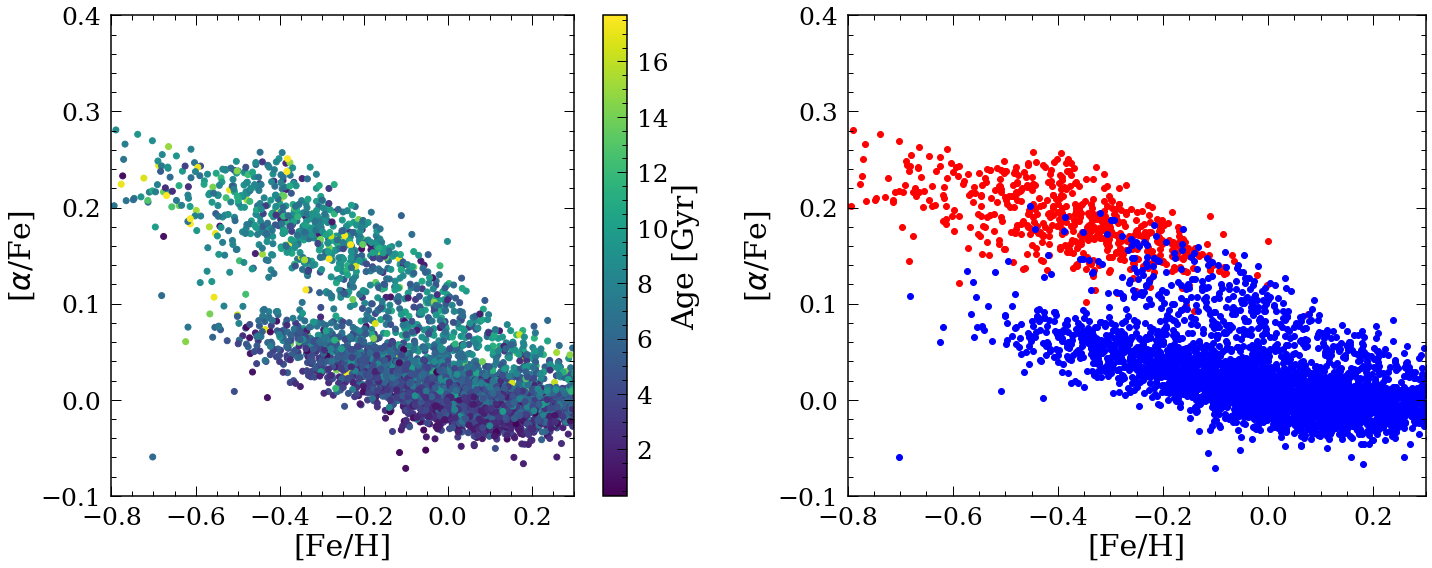

In [4]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',5)
plt.scatter(df['M_H'],df['ALPHA_M'],c=df['Age'])
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')
cb=plt.colorbar()
cb.set_label('Age [Gyr]')


high_alpha=df.loc[df['hi_low']==1]
low_alpha=df.loc[df['hi_low']==0]


plt.subplot(1,2,2)
plt.scatter(high_alpha['M_H'],high_alpha['ALPHA_M'],c='r')
plt.scatter(low_alpha['M_H'],low_alpha['ALPHA_M'],c='b')
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')

plt.tight_layout()

In [5]:
df_abun_st_ha=high_alpha.loc[abs(high_alpha['FeH']+0.2)<0.1]
#df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['GAIA_R_EST']-2000)<1000]

df_abun_st_la=low_alpha.loc[abs(low_alpha['FeH']+0.2)<0.1]
#df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['GAIA_R_EST']-2000)<1000]

print(len(df_abun_st_ha),len(df_abun_st_la))

234 598


4668.626074636084 8.009383566177092 0.4734416345050509


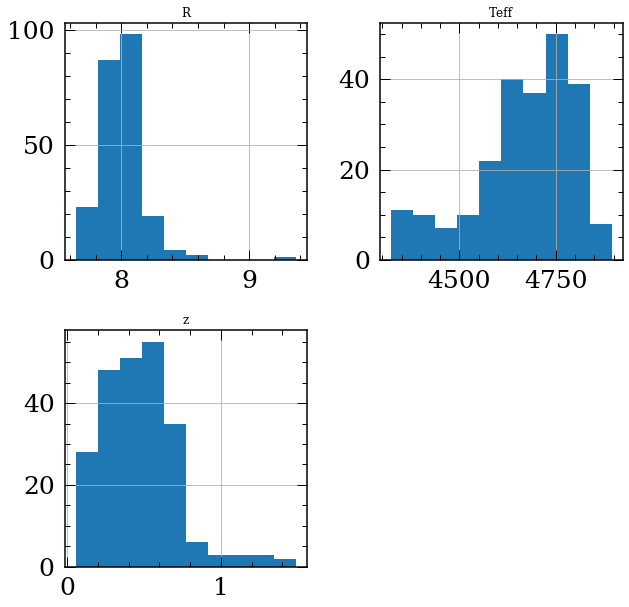

In [9]:
df_abun_st_ha[['R','z','Teff']].hist()
print(np.mean(df_abun_st_ha['Teff']),np.mean(df_abun_st_ha['R']),np.mean(df_abun_st_ha['z']))



In [10]:
rangeTeff=25
tempcut=4750

print(len(df_abun_st_ha))
df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['Teff']-tempcut)<rangeTeff]
df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['Teff']-tempcut)<rangeTeff]
print(len(df_abun_st_ha))


234
42


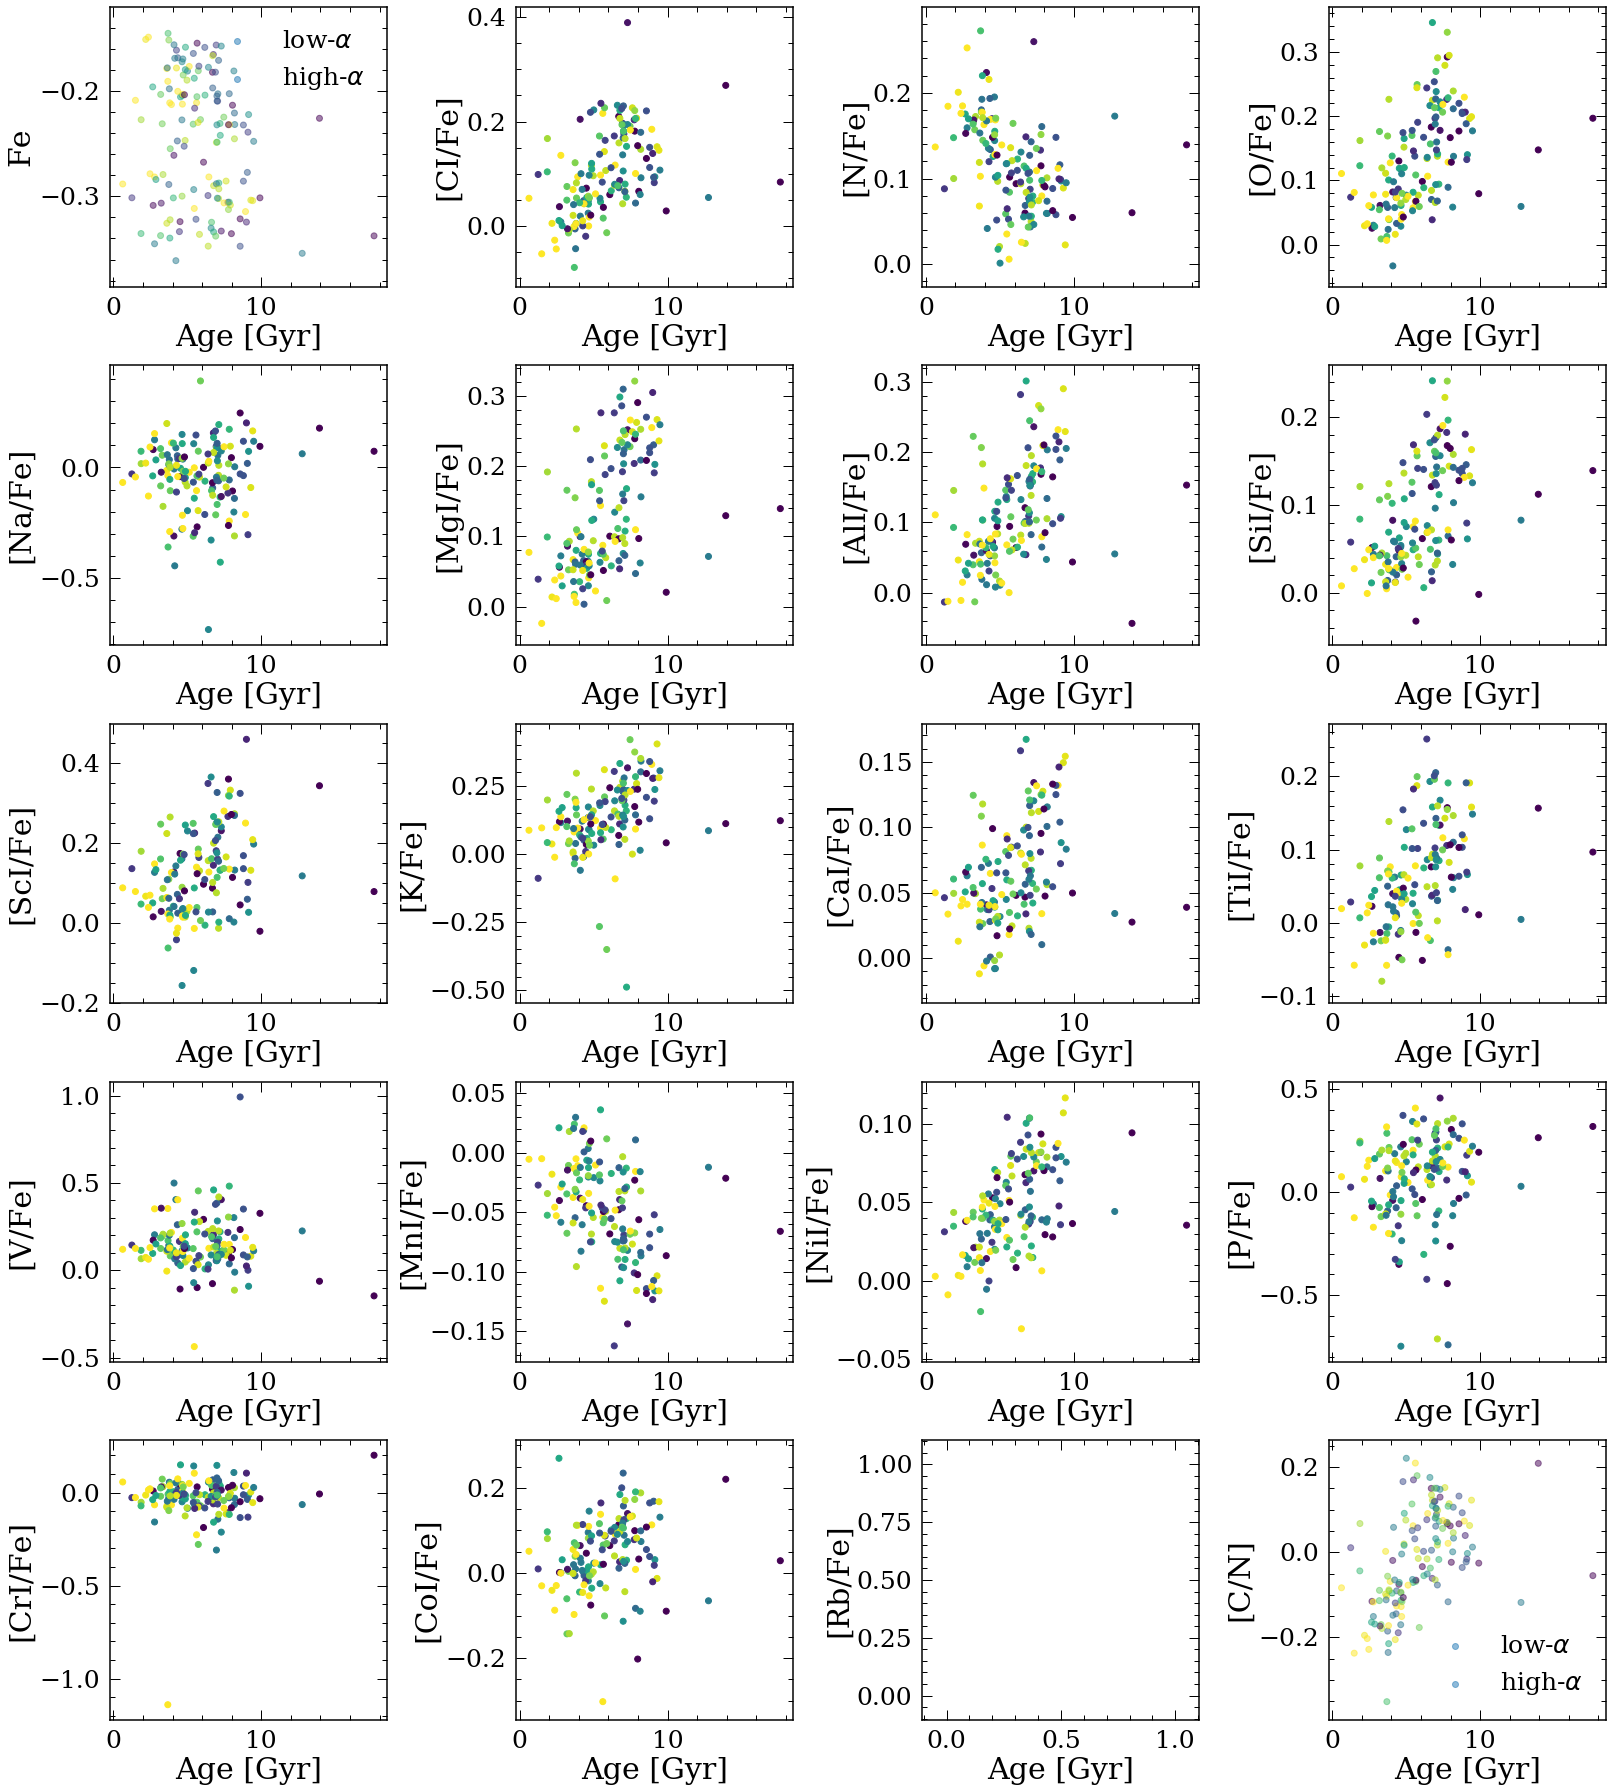

In [11]:
tempcheck(df_abun_st_ha,df_abun_st_la)

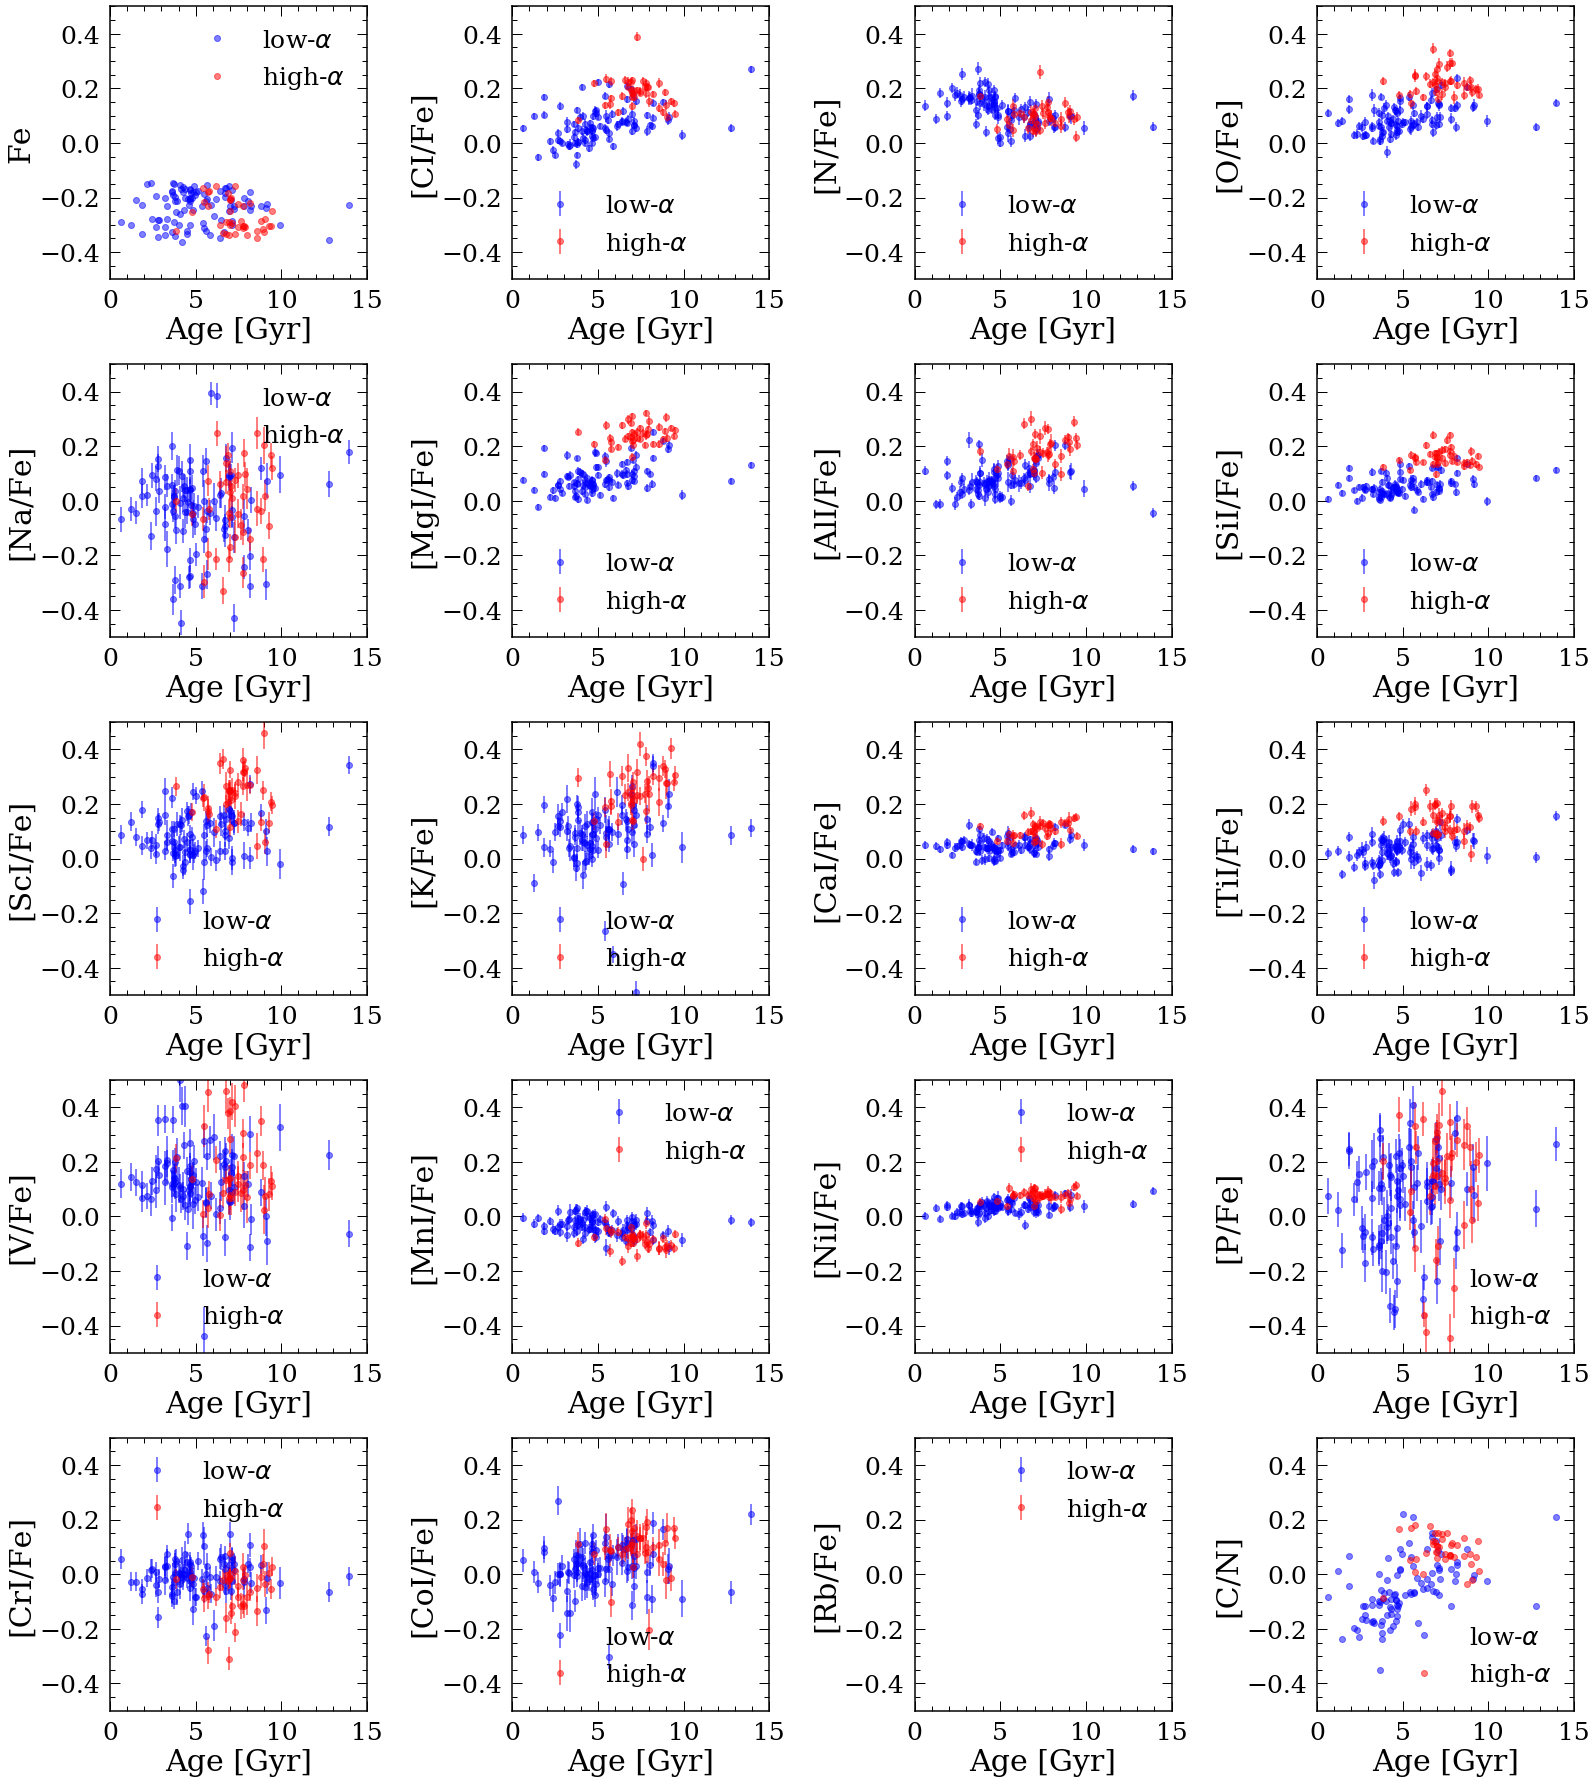

In [12]:
plotraw(df_abun_st_ha,df_abun_st_la)

100%|██████████| 100/100 [00:00<00:00, 587.06it/s]


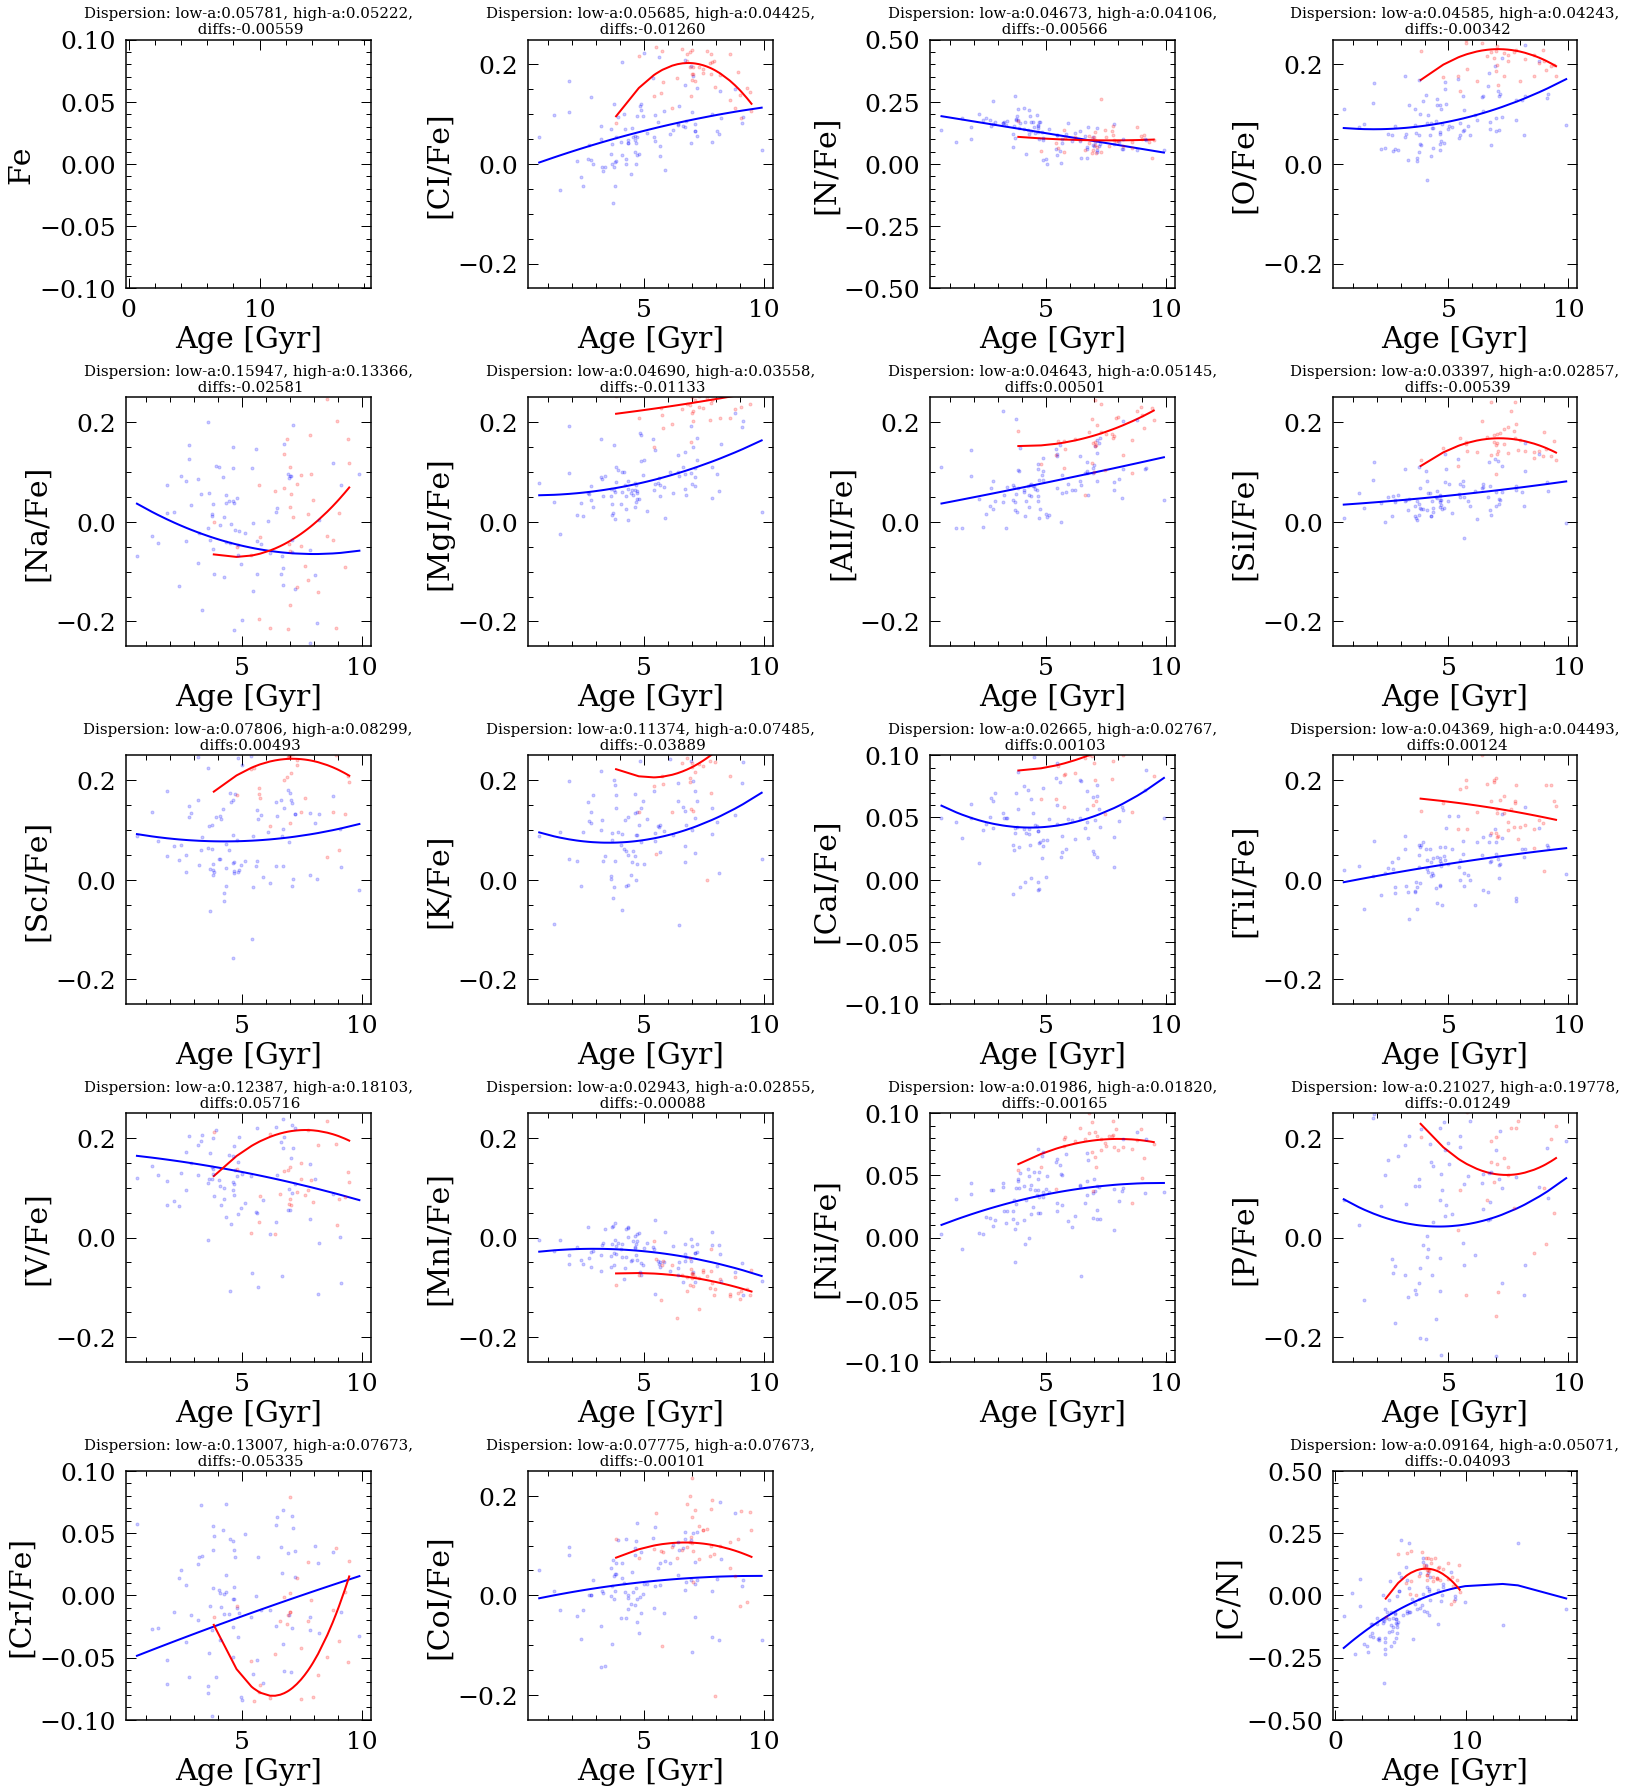

In [13]:
hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname=plotTrends(df_abun_st_ha,df_abun_st_la,'abundance','linear',2)



In [14]:
Abunname=[i.split('/')[0].split('[')[-1] for i in Abunname]
df_disp=pd.DataFrame(np.array((Abunname,lo_dis,hi_dis)).T,columns=['Abund','la_dis_astro','ha_dis_astro'])
lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis=zip(*sorted(zip(lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis)))
df_disp

Abund          la_dis_astro          ha_dis_astro
0     CI    0.0568502875453127   0.04424920203134394
1      N   0.04672844481677859   0.04106354513811901
2      O   0.04584897187970634   0.04242516935902955
3     Na   0.15947076935290544   0.13365956497349007
4    MgI   0.04690225084927757  0.035576879918680096
5    AlI   0.04643294249707942   0.05144648291326782
6    SiI   0.03396747972698304   0.02857308483080053
7    ScI   0.07806185104864101   0.08298898966656773
8      K   0.11374188562663323   0.07484896174593583
9    CaI  0.026647947951968537   0.02767355282258131
10   TiI   0.04368826716947222   0.04493194115560221
11     V   0.12386899017919988   0.18103244646500177
12   MnI  0.029431783241369996  0.028547530270336942
13   NiI  0.019857226733034847   0.01820332147061764
14     P    0.2102722436179248    0.1977827499361013
15   CrI   0.13007081929613273   0.07672560877217358
16   CoI   0.07774844343093841   0.07673405778884865
17    Fe   0.05780907290187499    0.0522227606738567
18     C   0.09164103429633594  0.050708906858930806

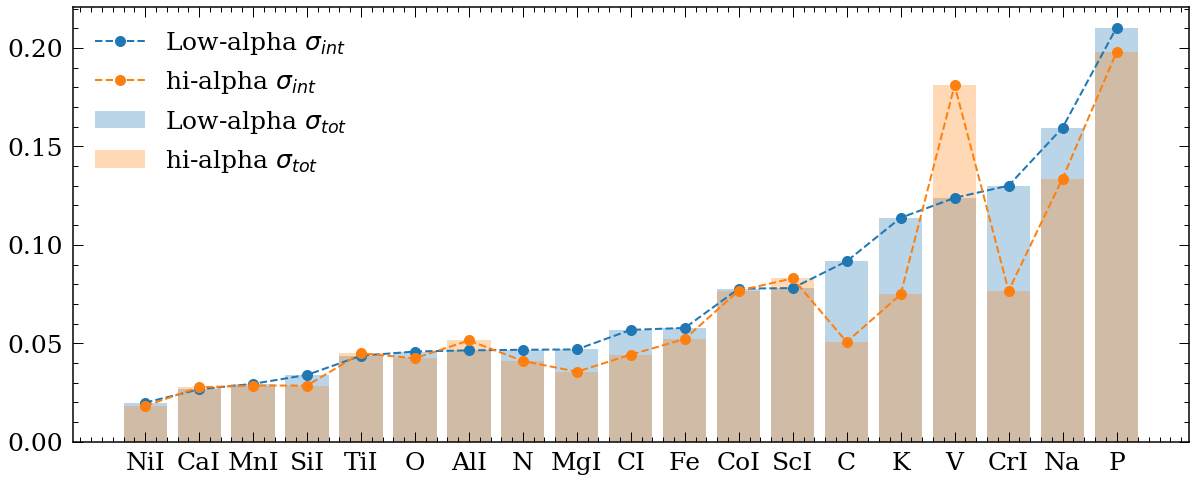

In [15]:
plt.figure(figsize=(20,8))
plt.plot(Abunname,lo_dis,'--o',label='Low-alpha $\sigma_{int}$',markersize=10)
plt.plot(Abunname,hi_dis,'--o',label='hi-alpha $\sigma_{int}$',markersize=10)
plt.bar(Abunname,tot_lo_dis,label='Low-alpha $\sigma_{tot}$',alpha=0.3)
plt.bar(Abunname,tot_hi_dis,label='hi-alpha $\sigma_{tot}$',alpha=0.3)
plt.legend()
#plt.savefig('dispersion_astro.png')

In [16]:
abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','ALPHA_M']
print(len(abun_apog))

19


In [23]:
df_CM=pd.read_pickle('CannonDR16_cut.pkl')
for i in abun_apog:
    df_CM=df_CM.loc[abs(df_CM[i])<5]
df_CM=df_CM.reset_index(drop=True)
print('before cutting:',len(df_CM))
# After cutting
#df=df.loc[abs(df['[Mg/Fe]']-df['MG_FE'])<0.2]
#df=df.loc[df['TEFF']<5200]
#print('after cutting:',len(df))

# get red clump stars
df=df_CM.loc[df_CM['DP']>230]




before cutting: 64399


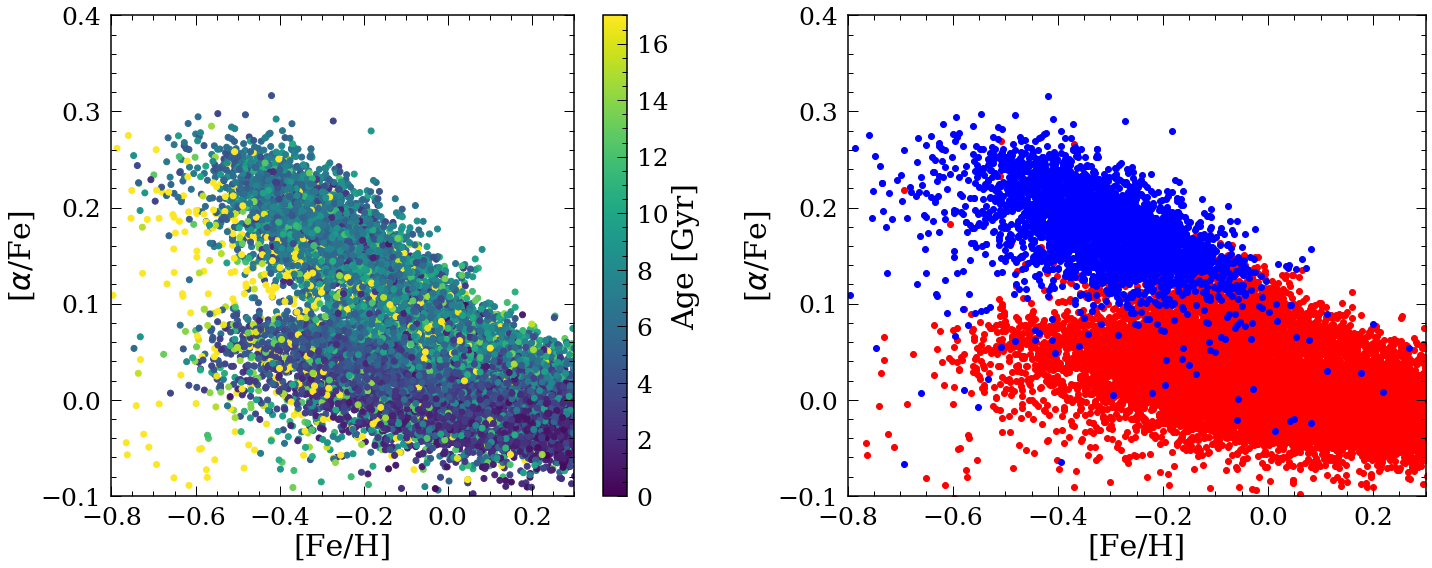

In [24]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',5)
plt.scatter(df['M_H'],df['ALPHA_M'],c=df['Age'],vmin=0,vmax=17)
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')
cb=plt.colorbar()
cb.set_label('Age [Gyr]')

high_alpha=df.loc[df['hi_low']==0]
low_alpha=df.loc[df['hi_low']==1]

plt.subplot(1,2,2)
plt.scatter(high_alpha['M_H'],high_alpha['ALPHA_M'],c='r')
plt.scatter(low_alpha['M_H'],low_alpha['ALPHA_M'],c='b')
plt.xlim([-0.8,0.3])
plt.ylim([-0.1,0.4])
plt.xlabel('[Fe/H]')
plt.ylabel('[$\\alpha$/Fe]')

plt.tight_layout()


In [26]:
df_abun_st_ha=high_alpha.loc[abs(high_alpha['M_H']+0.2)<0.1]
#df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['GAIA_R_EST']-2000)<1000]

df_abun_st_la=low_alpha.loc[abs(low_alpha['M_H']+0.2)<0.1]
#df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['GAIA_R_EST']-2000)<1000]

print(len(df_abun_st_ha),len(df_abun_st_la))

3986 1554


In [28]:
rangeTeff=25
tempcut=4750

print(len(df_abun_st_ha))
df_abun_st_ha=df_abun_st_ha.loc[abs(df_abun_st_ha['TEFF']-tempcut)<rangeTeff]
df_abun_st_la=df_abun_st_la.loc[abs(df_abun_st_la['TEFF']-tempcut)<rangeTeff]
print(len(df_abun_st_ha))



3986
590


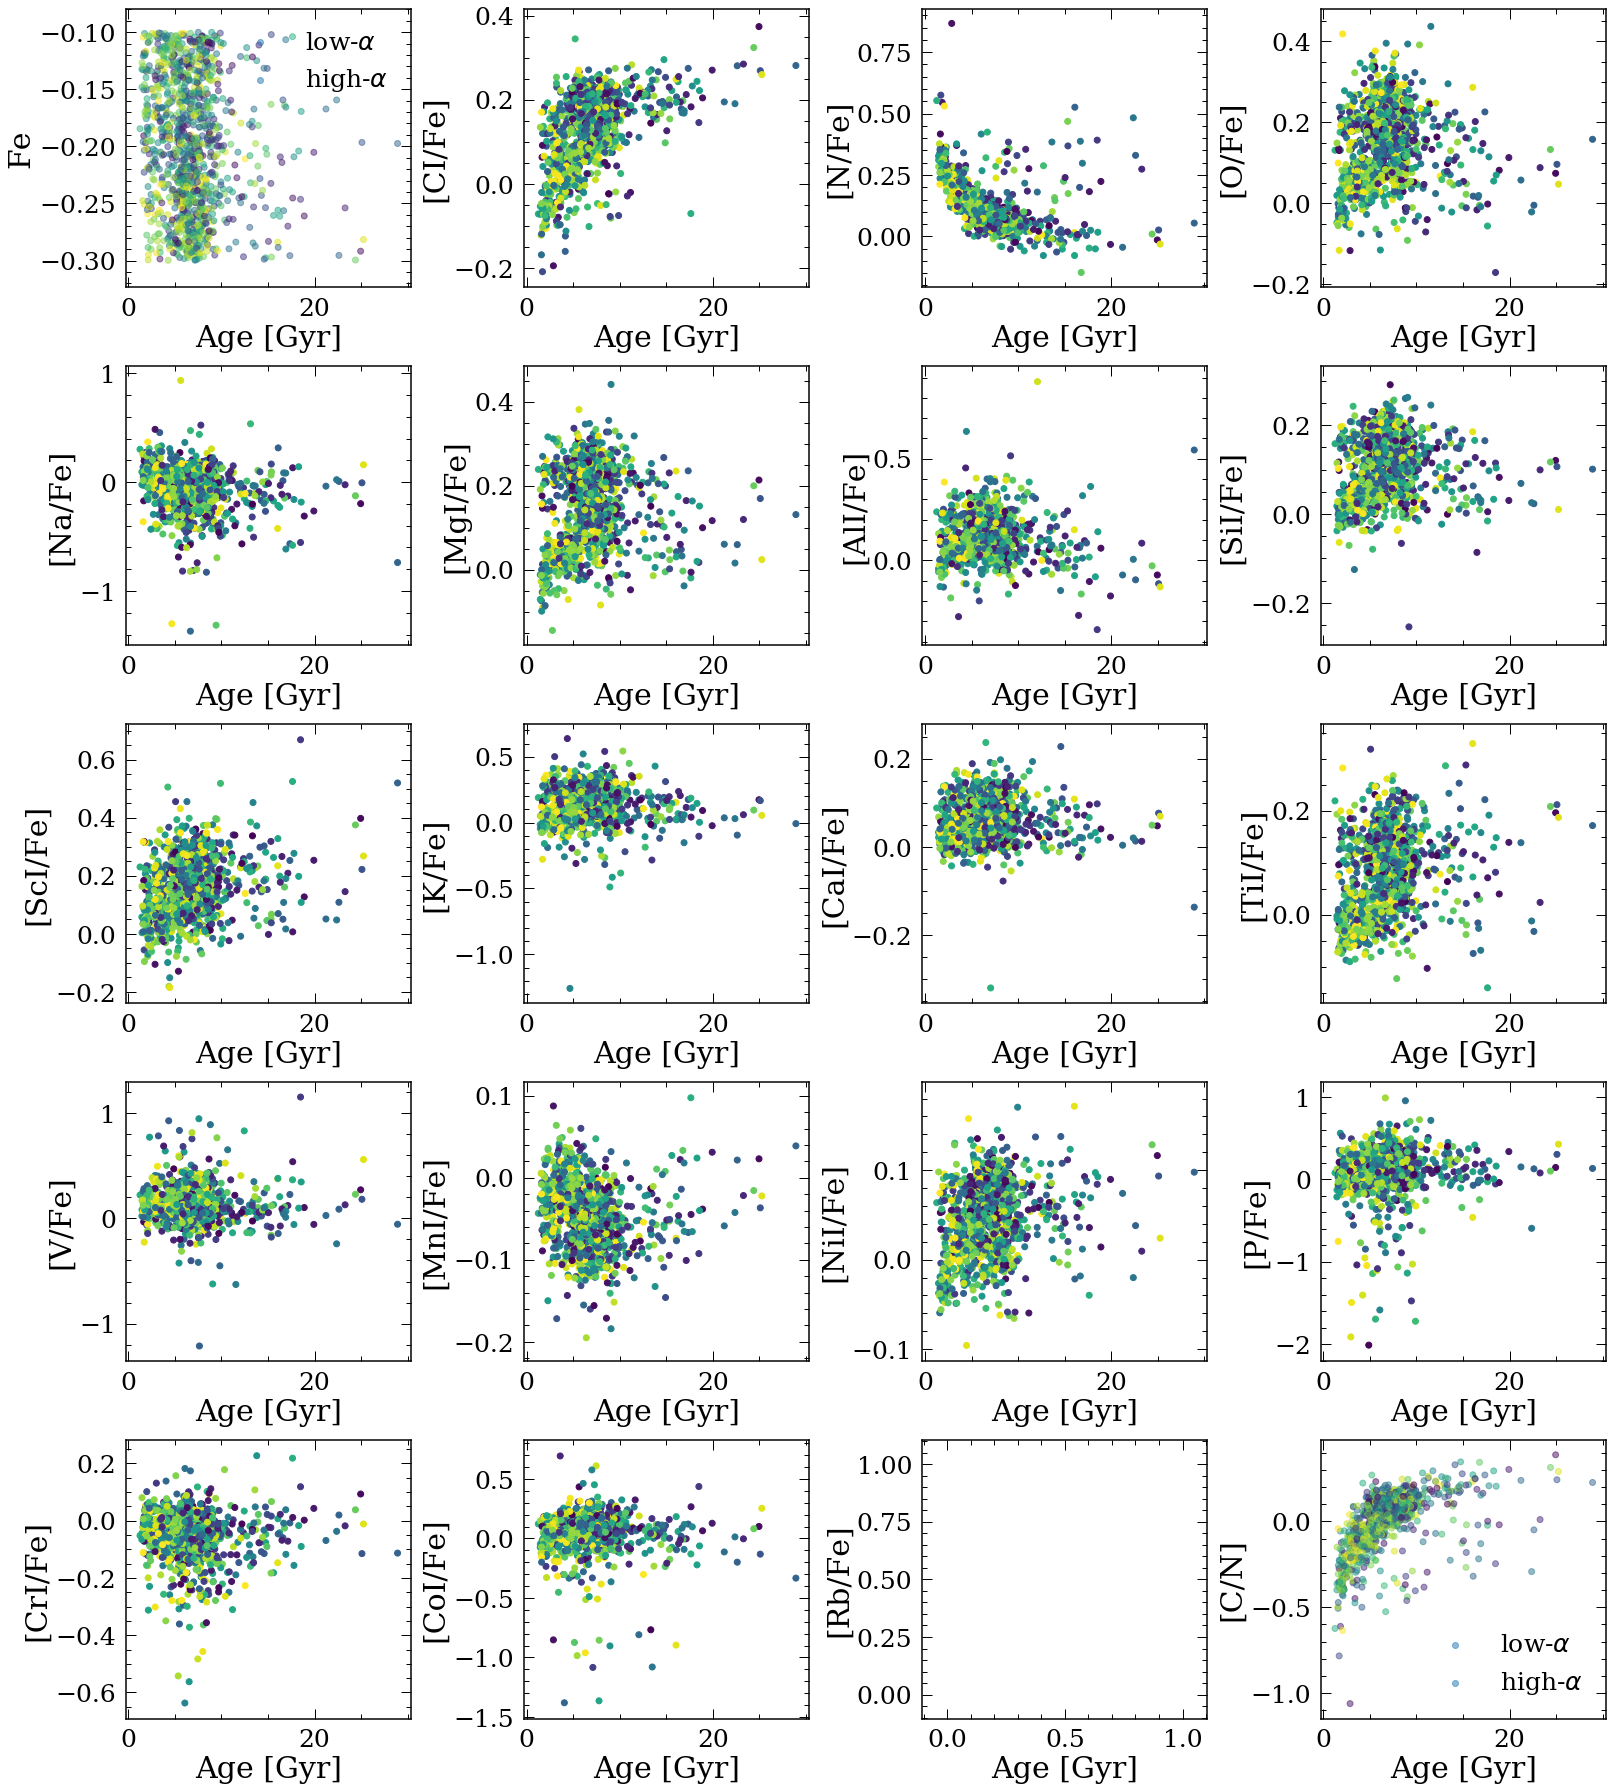

In [29]:
tempcheck(df_abun_st_ha,df_abun_st_la)

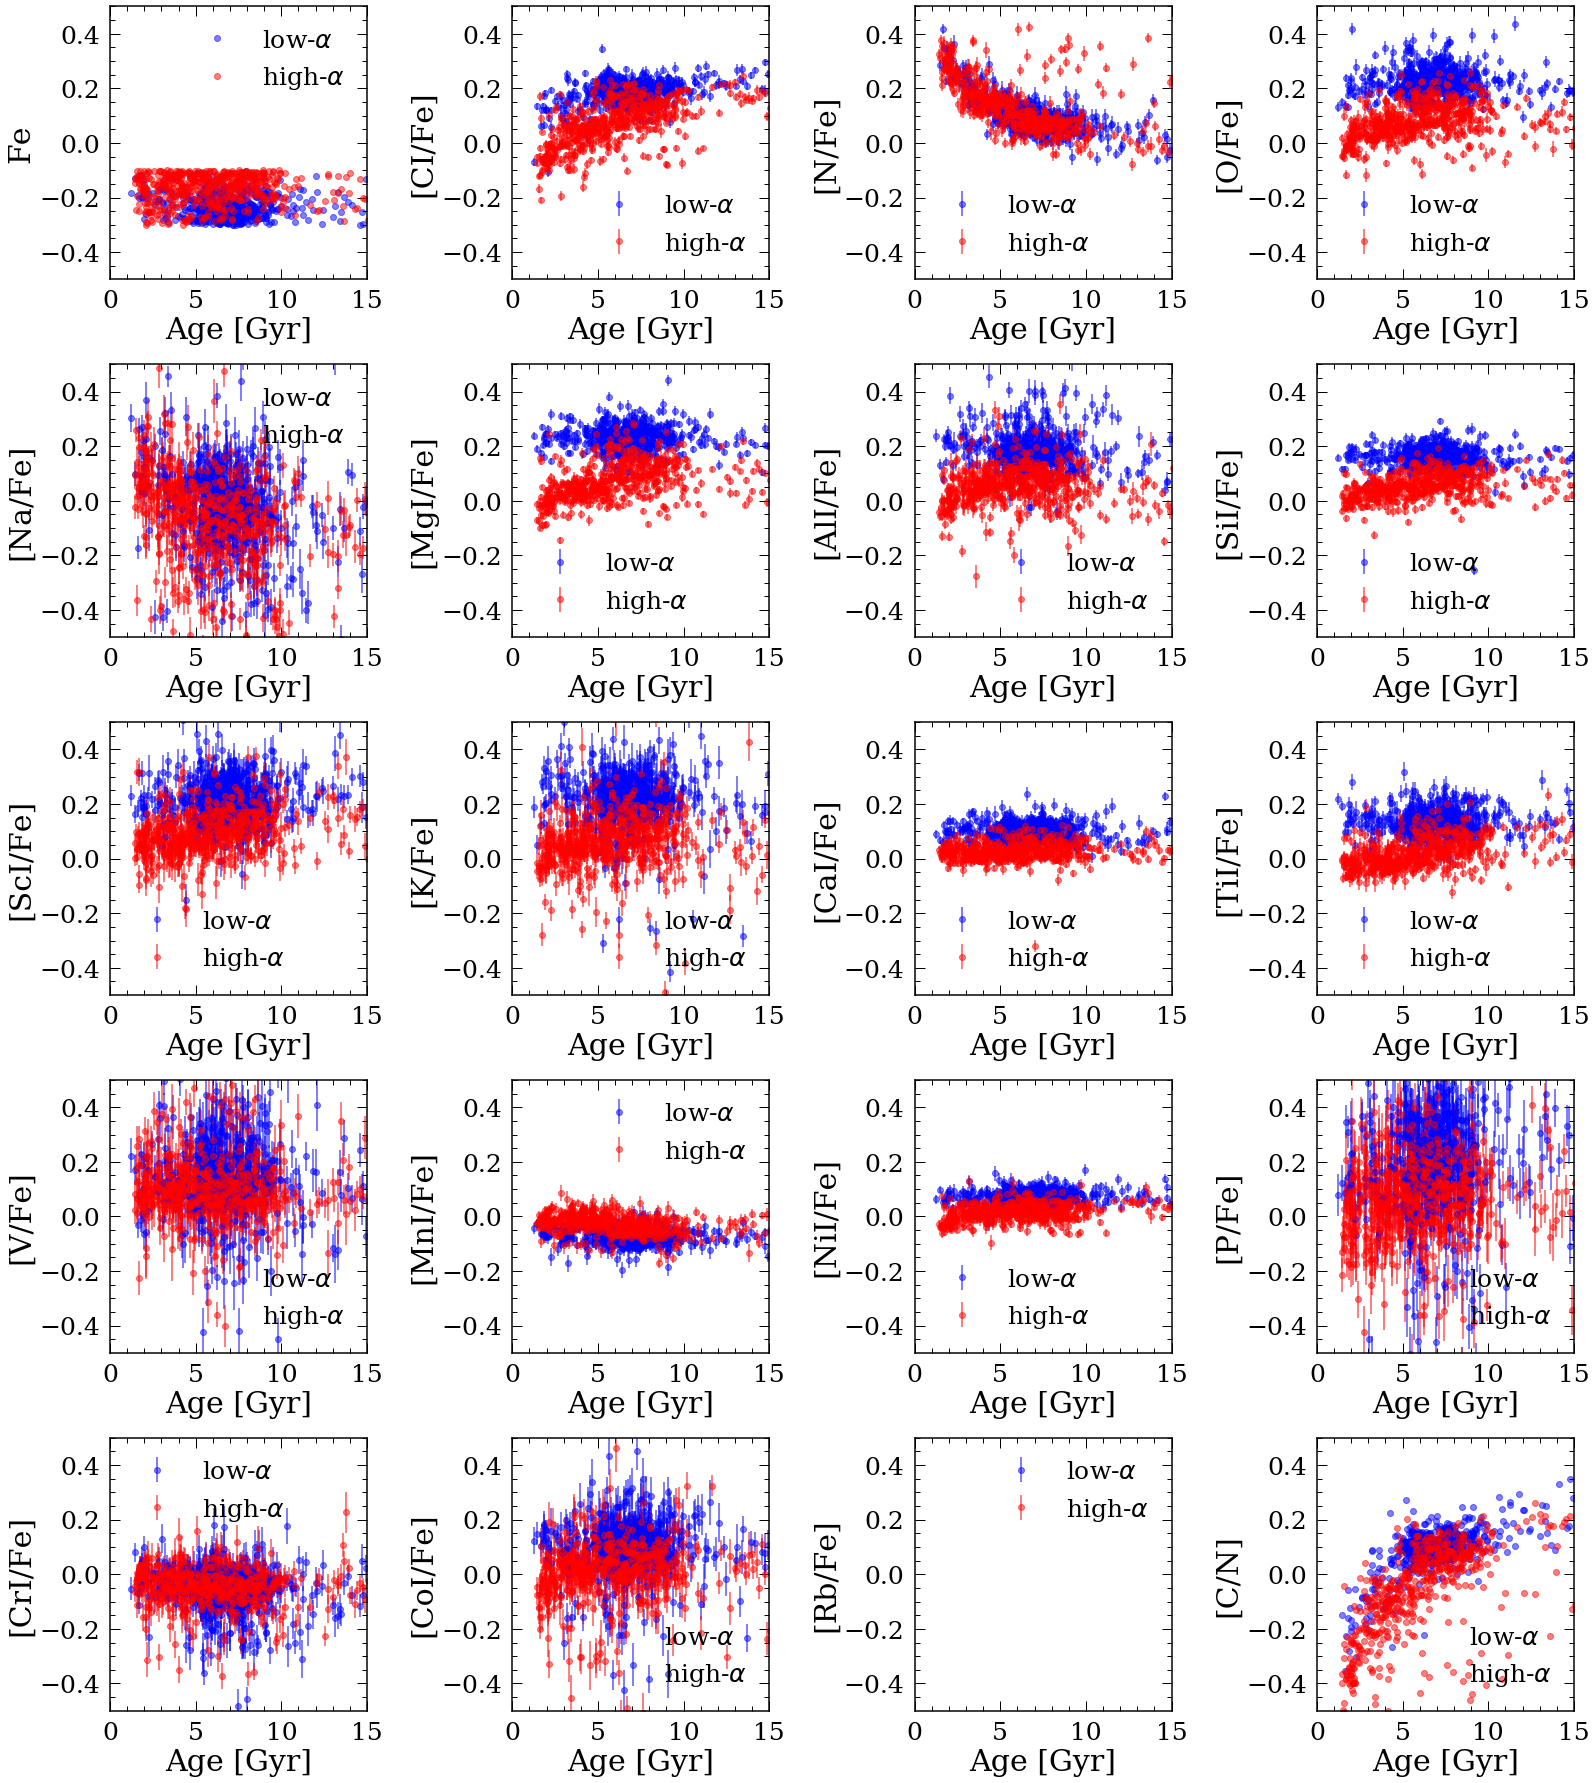

In [30]:
plotraw(df_abun_st_ha,df_abun_st_la)



100%|██████████| 100/100 [00:00<00:00, 104.01it/s]


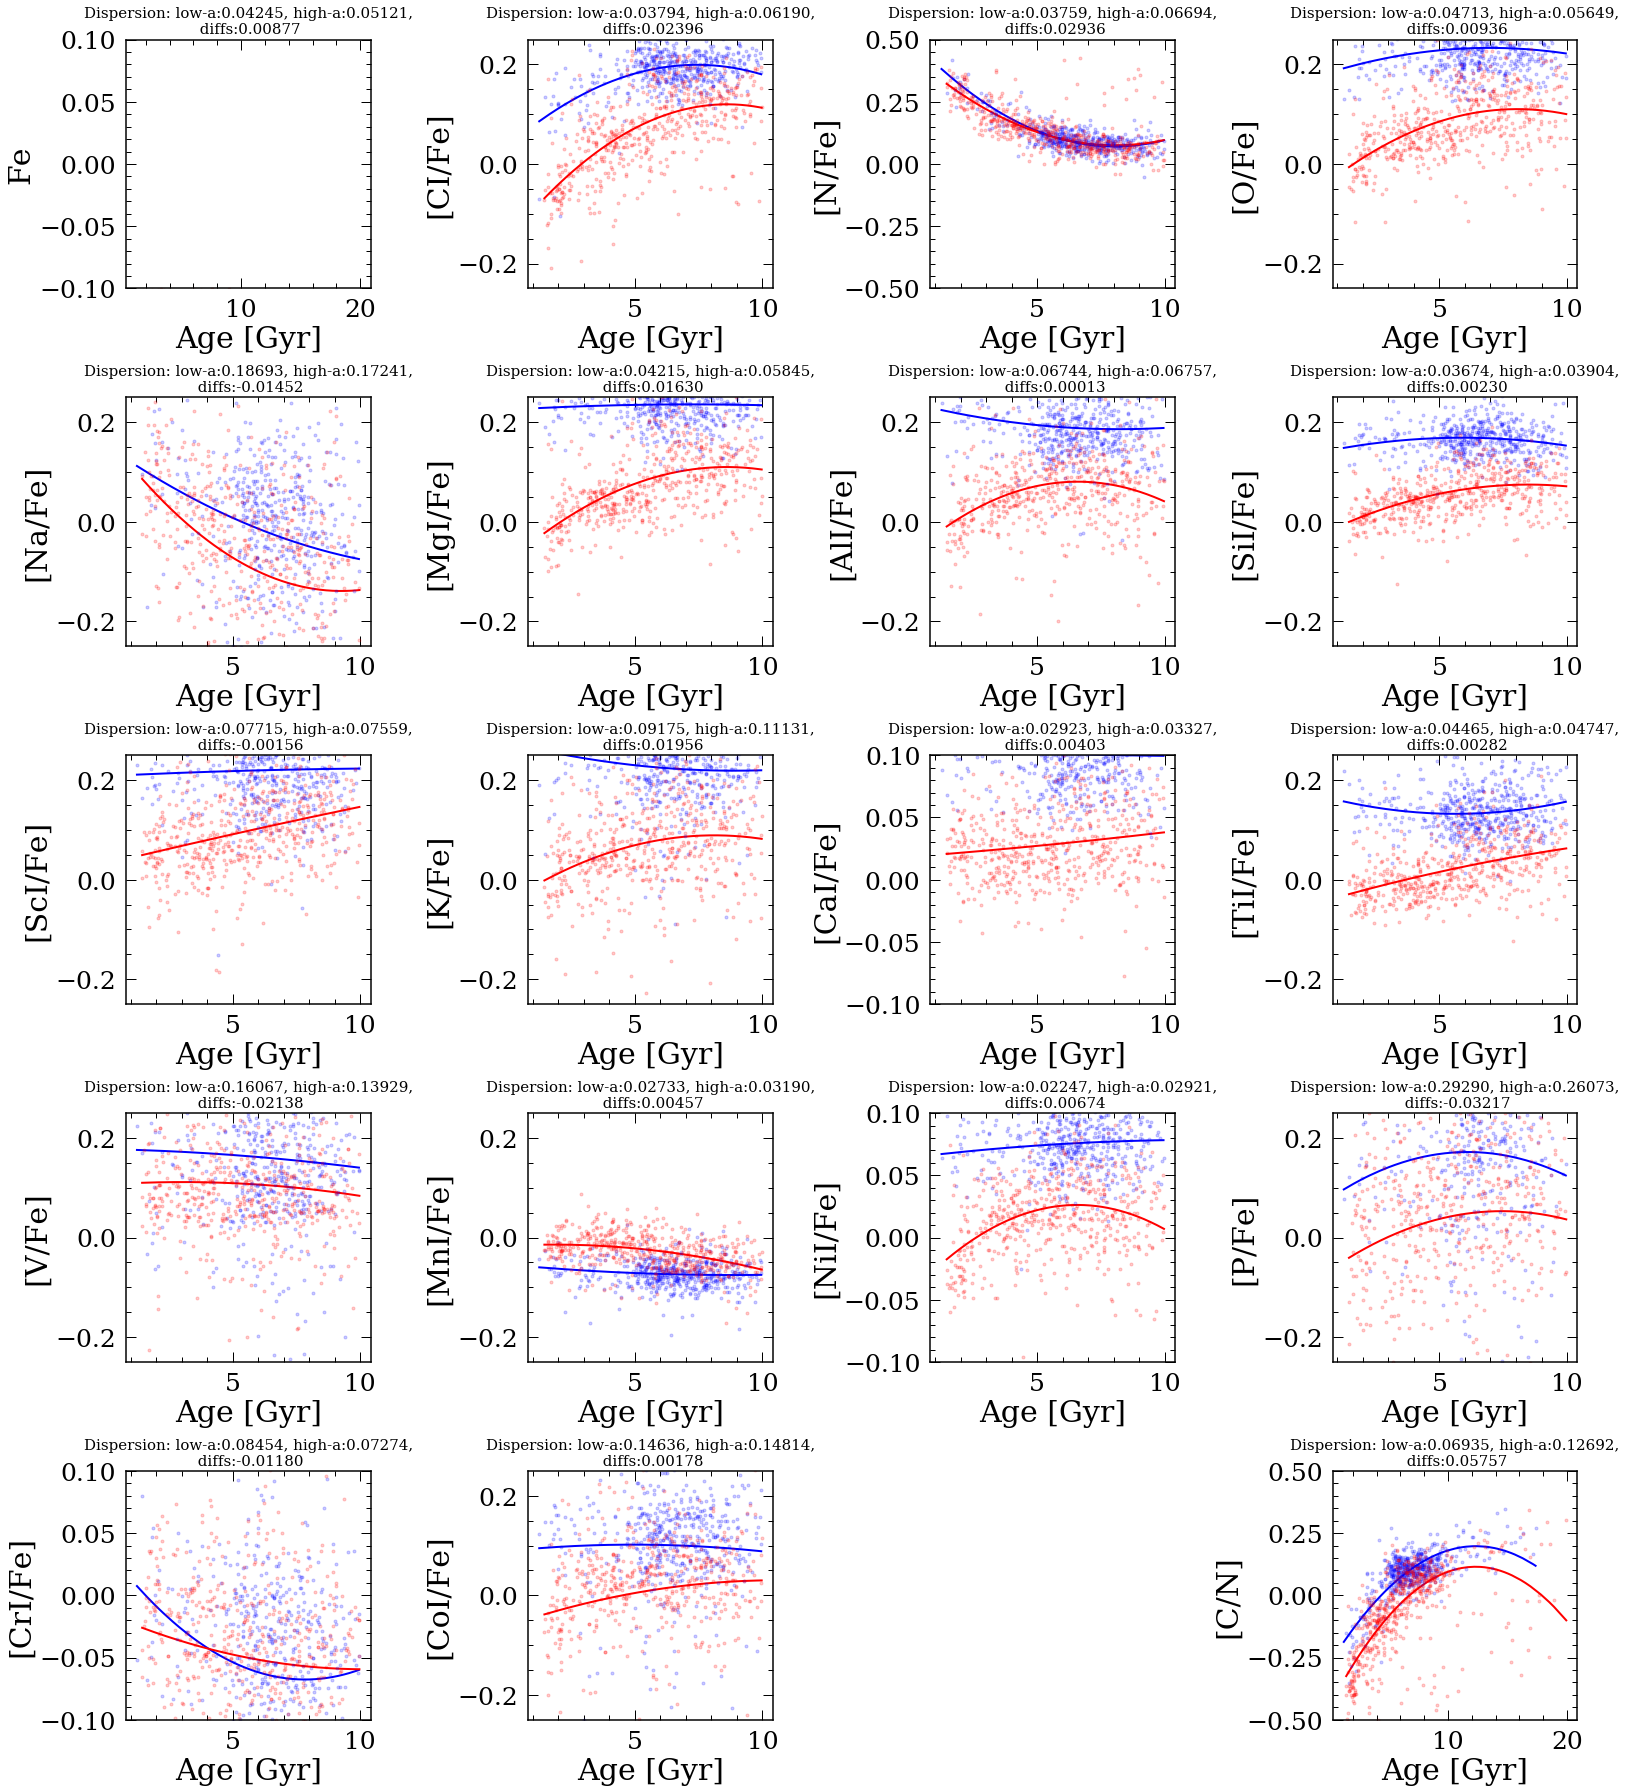

In [31]:
#hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname=plotTrends(df_abun_st_ha,df_abun_st_la,'abundance_cannon_rc')
hi_dis, lo_dis, tot_hi_dis, tot_lo_dis, Abunname=plotTrends(df_abun_st_ha,df_abun_st_la,'abundance_cannon_rc','linear',2)



In [32]:
Abunname=[i.split('/')[0].split('[')[-1] for i in Abunname]
df_disp_rc=pd.DataFrame(np.array((Abunname,lo_dis,hi_dis)).T,columns=['Abund','la_dis_rc','ha_dis_rc'])

lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis=zip(*sorted(zip(lo_dis,Abunname,hi_dis,tot_lo_dis,tot_hi_dis)))
#tot_lo_dis,lo_dis,Abunname,hi_dis,tot_hi_dis=zip(*sorted(zip(tot_lo_dis,lo_dis,Abunname,hi_dis,tot_hi_dis)))
df_disp_rc

Abund             la_dis_rc             ha_dis_rc
0     CI   0.03794364822379192   0.06190426676471462
1      N   0.03758661343625763   0.06694205656944376
2      O   0.04713281827805381   0.05649493042274889
3     Na    0.1869325965027419   0.17240965777286985
4    MgI   0.04215227817228996  0.058450865110295895
5    AlI   0.06744252623524964   0.06756755815025009
6    SiI  0.036740900919459675   0.03904247882724317
7    ScI   0.07715499678809123   0.07559293535826475
8      K   0.09175107321084382   0.11130632176064825
9    CaI  0.029234437560582006   0.03326605002075231
10   TiI   0.04465320191589148   0.04747360607585182
11     V   0.16067002332243158    0.1392918840336615
12   MnI  0.027331653779211096  0.031902520293074575
13   NiI  0.022469596552376077  0.029212358123705044
14     P    0.2928988024292344    0.2607280847690939
15   CrI   0.08453635430074306   0.07273940622504538
16   CoI     0.146363637862105   0.14813874483324427
17    Fe    0.0424456390388033  0.051213956815457276
18     C   0.06935049874045174    0.1269210159394061

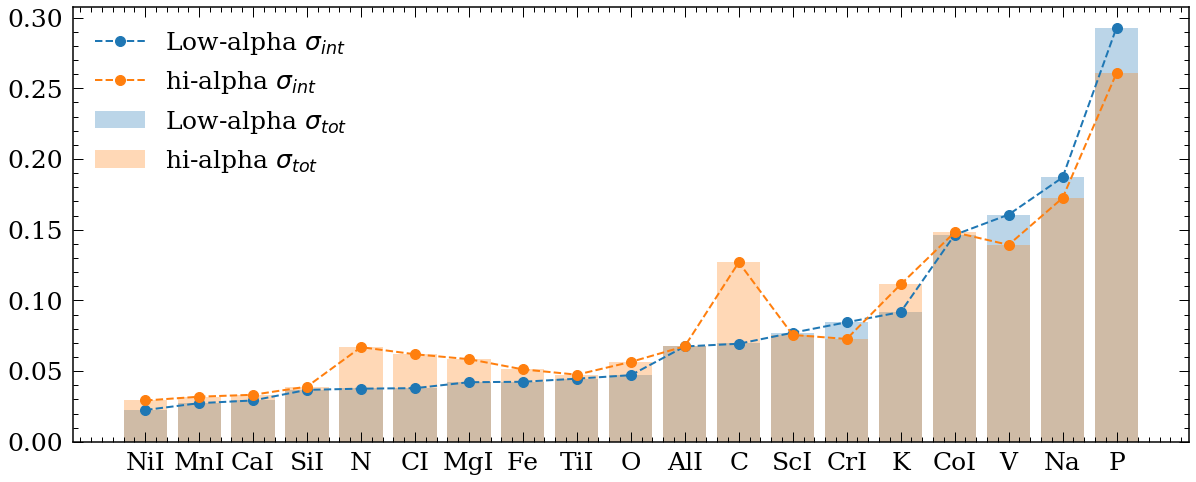

In [33]:
plt.figure(figsize=(20,8))
plt.plot(Abunname,lo_dis,'--o',label='Low-alpha $\sigma_{int}$',markersize=10)
plt.plot(Abunname,hi_dis,'--o',label='hi-alpha $\sigma_{int}$',markersize=10)
plt.bar(Abunname,tot_lo_dis,label='Low-alpha $\sigma_{tot}$',alpha=0.3)
plt.bar(Abunname,tot_hi_dis,label='hi-alpha $\sigma_{tot}$',alpha=0.3)
plt.legend()
#plt.savefig('dispersion_cannon_rc.png')

In [34]:
df_disp_plot=pd.merge(df_disp,df_disp_rc,left_on='Abund',right_on='Abund',how='inner')
for i in df_disp_plot.columns:
    if i!='Abund':
        df_disp_plot[i]=[float(j) for j in df_disp_plot[i]]
#df_disp_plot.to_pickle('intrinsic.pkl')
df_disp_plot['Abund'].iloc[18]='C/N'

/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [35]:

df_abun_st_ha['C_N']=df_abun_st_ha['C_FE']-df_abun_st_ha['N_FE']
df_abun_st_ha['C_N_ERR']=np.sqrt(df_abun_st_ha['C_FE_ERR']**2.+df_abun_st_ha['N_FE_ERR']**2.)


df_abun_st_la['C_N']=df_abun_st_la['C_FE']-df_abun_st_la['N_FE']
df_abun_st_la['C_N_ERR']=np.sqrt(df_abun_st_la['C_FE_ERR']**2.+df_abun_st_la['N_FE_ERR']**2.)



/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
df_disp_plot

Abund  la_dis_astro  ha_dis_astro  la_dis_rc  ha_dis_rc
0     CI      0.056850      0.044249   0.037944   0.061904
1      N      0.046728      0.041064   0.037587   0.066942
2      O      0.045849      0.042425   0.047133   0.056495
3     Na      0.159471      0.133660   0.186933   0.172410
4    MgI      0.046902      0.035577   0.042152   0.058451
5    AlI      0.046433      0.051446   0.067443   0.067568
6    SiI      0.033967      0.028573   0.036741   0.039042
7    ScI      0.078062      0.082989   0.077155   0.075593
8      K      0.113742      0.074849   0.091751   0.111306
9    CaI      0.026648      0.027674   0.029234   0.033266
10   TiI      0.043688      0.044932   0.044653   0.047474
11     V      0.123869      0.181032   0.160670   0.139292
12   MnI      0.029432      0.028548   0.027332   0.031903
13   NiI      0.019857      0.018203   0.022470   0.029212
14     P      0.210272      0.197783   0.292899   0.260728
15   CrI      0.130071      0.076726   0.084536   0.072739
16   CoI      0.077748      0.076734   0.146364   0.148139
17    Fe      0.057809      0.052223   0.042446   0.051214
18   C/N      0.091641      0.050709   0.069350   0.126921

In [37]:
elements=['C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE','V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','M_H','C_N']
ha_err=[]
la_err=[]
for i in elements:
    df_abun_st_ha=df_abun_st_ha.loc[df_abun_st_ha[i+"_ERR"]>0]
    df_abun_st_la=df_abun_st_la.loc[df_abun_st_la[i+"_ERR"]>0]
    ha_err.append(np.mean(df_abun_st_ha[i+"_ERR"].dropna()))
    la_err.append(np.mean(df_abun_st_la[i+"_ERR"].dropna()))
    
df_disp_plot['ha_err_all']=ha_err
df_disp_plot['la_err_all']=la_err



In [38]:
df_disp_plot['diff']=abs(df_disp_plot['la_dis_astro']-df_disp_plot['ha_dis_astro'])

In [39]:
df_disp_plot=df_disp_plot.sort_values(by='diff')

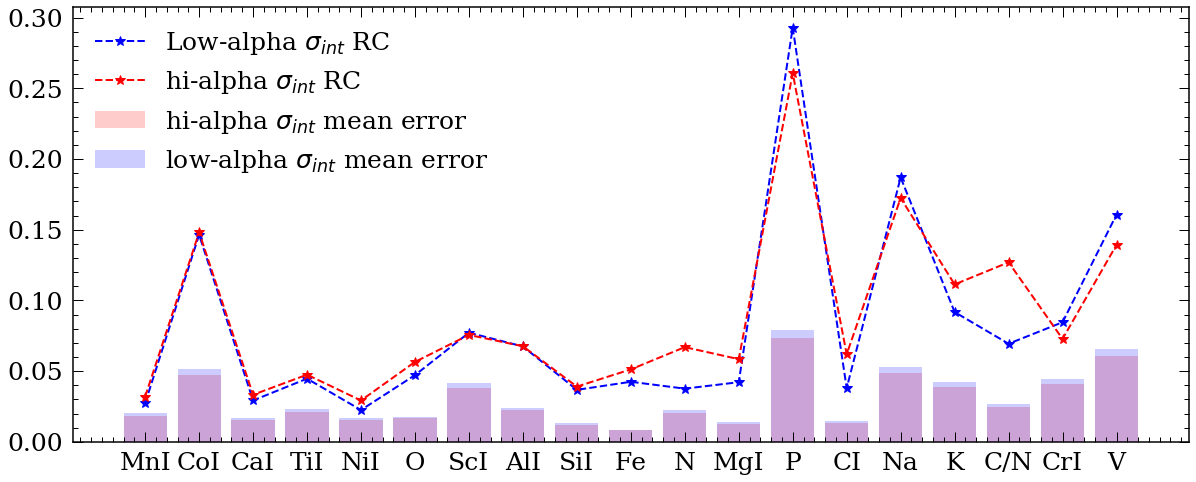

In [40]:
plt.figure(figsize=(20,8))
#plt.plot(df_disp_plot['Abund'],df_disp_plot['la_dis_astro'],'b--o',label='Low-alpha $\sigma_{int}$ Astro',markersize=10)
#plt.plot(df_disp_plot['Abund'],df_disp_plot['ha_dis_astro'],'r--o',label='hi-alpha $\sigma_{int}$ Astro',markersize=10)

plt.plot(df_disp_plot['Abund'],df_disp_plot['la_dis_rc'],'b--*',label='Low-alpha $\sigma_{int}$ RC',markersize=10)
plt.plot(df_disp_plot['Abund'],df_disp_plot['ha_dis_rc'],'r--*',label='hi-alpha $\sigma_{int}$ RC',markersize=10)

#plt.plot(df_disp_plot['Abund'],df_disp_plot['la_dis_all'],'b--.',label='Low-alpha $\sigma_{int}$ all',markersize=10)
#plt.plot(df_disp_plot['Abund'],df_disp_plot['ha_dis_all'],'r--.',label='hi-alpha $\sigma_{int}$ all',markersize=10)

plt.bar(df_disp_plot['Abund'].values,df_disp_plot['ha_err_all'].values,alpha=0.2,
        color='r',label='hi-alpha $\sigma_{int}$ mean error')
plt.bar(df_disp_plot['Abund'].values,df_disp_plot['la_err_all'].values,alpha=0.2,
        color='b',label='low-alpha $\sigma_{int}$ mean error')

plt.legend()
#plt.savefig('dispersion_comp_2dpoly_rc.png')

# gradient

In [41]:
"""
# log age errors
def calcgrad(age,abund,age_err,abund_err):
    zs=np.zeros(100)
    bs=np.zeros(100)
    for i in trange(100):
        newage=np.array([np.random.normal(age[k], age_err[k],1)[0] for k in range(len(age))])
        newage=10**newage/1000
        newabund=np.array([np.random.normal(abund[k], abund_err[k],1)[0] for k in range(len(abund))])
        fits=np.polyfit(newage,newabund,1)
        p=np.poly1d(fits)
        plt.plot(newage,p(newage),'r-',alpha=0.5)
        zs[i] = fits[0]
        bs[i] = fits[1]
    fits=np.polyfit(age,abund,1)
    p=np.poly1d(fits)
    plt.plot(age,p(age),'k-',alpha=0.5,linewidth=5)
    return np.mean(zs),np.std(zs),np.mean(bs),np.std(bs)
"""
"""
# with age err
def calcgrad(age,abund,age_err,abund_err):
    sampsize=50
    plt.plot(age,abund,'.',markersize=5)
    zs=np.zeros(sampsize)
    bs=np.zeros(sampsize)
    for i in trange(sampsize):
        newage=np.array([np.random.normal(age[k], age_err[k],1)[0] for k in range(len(age))])
        newabund=np.array([np.random.normal(abund[k], abund_err[k],1)[0] for k in range(len(abund))])
        fits=np.polyfit(newage,newabund,1)
        #fits=np.polyfit(age,newabund,1)
        zs[i] = fits[0]
        bs[i] = fits[1]
    fits=np.polyfit(age,abund,1)
    return fits[0],np.std(zs),fits[1],np.std(bs)
"""


# without age error
def calcgrad(age,abund,age_err,abund_err):
    sampsize=100
    #plt.plot(age,abund,'.',markersize=5)
    zs=np.zeros(sampsize)
    bs=np.zeros(sampsize)
    for i in trange(sampsize):
        #newage=np.array([np.random.normal(age[k], age_err[k],1)[0] for k in range(len(age))])
        newabund=np.array([np.random.normal(abund[k], abund_err[k],1)[0] for k in range(len(abund))])
        fits=np.polyfit(age,newabund,1)
        #fits=np.polyfit(age,newabund,1)
        zs[i] = fits[0]
        bs[i] = fits[1]

    return np.mean(zs),np.std(zs),np.mean(bs),np.std(bs)


"""
def calcgrad(age,abund,age_err,abund_err):
    sampsize=100
    plt.errorbar(age,abund,yerr=abund_err,fmt='k.',markersize=5,alpha=0.5)
    zs=np.zeros(sampsize)
    bs=np.zeros(sampsize)
    for i in trange(sampsize):
        newage=np.array([np.random.normal(age[k], age_err[k],1)[0] for k in range(len(age))])
        newabund=np.array([np.random.normal(abund[k], abund_err[k],1)[0] for k in range(len(abund))])
        
        plt.plot(newage,newabund,'.',markersize=1,alpha=0.5)
        #plt.plot(age,newabund,'.',markersize=5,alpha=0.01)
        fits=np.polyfit(newage,newabund,1)
        #fits=np.polyfit(age,newabund,1)
        p=np.poly1d(fits)
        plt.plot(newage,p(newage),'r-',alpha=0.5)
        #plt.plot(age,p(age),'r-',alpha=0.5)
        zs[i] = fits[0]
        bs[i] = fits[1]
    fits=np.polyfit(age,abund,1)
    p=np.poly1d(fits)
    plt.plot(age,p(age),'k-',alpha=0.5,linewidth=5)
    print(np.mean(zs))
    print(fits[0])
    return fits[0],np.std(zs),fits[1],np.std(bs)
"""



"\ndef calcgrad(age,abund,age_err,abund_err):\n    sampsize=100\n    plt.errorbar(age,abund,yerr=abund_err,fmt='k.',markersize=5,alpha=0.5)\n    zs=np.zeros(sampsize)\n    bs=np.zeros(sampsize)\n    for i in trange(sampsize):\n        newage=np.array([np.random.normal(age[k], age_err[k],1)[0] for k in range(len(age))])\n        newabund=np.array([np.random.normal(abund[k], abund_err[k],1)[0] for k in range(len(abund))])\n        \n        plt.plot(newage,newabund,'.',markersize=1,alpha=0.5)\n        #plt.plot(age,newabund,'.',markersize=5,alpha=0.01)\n        fits=np.polyfit(newage,newabund,1)\n        #fits=np.polyfit(age,newabund,1)\n        p=np.poly1d(fits)\n        plt.plot(newage,p(newage),'r-',alpha=0.5)\n        #plt.plot(age,p(age),'r-',alpha=0.5)\n        zs[i] = fits[0]\n        bs[i] = fits[1]\n    fits=np.polyfit(age,abund,1)\n    p=np.poly1d(fits)\n    plt.plot(age,p(age),'k-',alpha=0.5,linewidth=5)\n    print(np.mean(zs))\n    print(fits[0])\n    return fits[0],np.std(zs

In [42]:
def getgrad(df_abun_st_ha,df_abun_st_la):
    abun_apog=['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','S_FE','K_FE','CA_FE','TI_FE',
           'V_FE','MN_FE','NI_FE','P_FE','CR_FE','CO_FE','RB_FE']

    abun_apog_err=[i+'_ERR' for i in abun_apog]

    abund={'C_FE':'[CI/','MG_FE':'[MgI/','AL_FE':'[AlI/','SI_FE':'[SiI/','S_FE':'[ScI/',
       'CA_FE':'[CaI/','TI_FE':'[TiI/','CR_FE':'[CrI/','MN_FE':'[MnI/','CO_FE':'[CoI/',
       'NI_FE':'[NiI/','CU_FE':'[CuI/','O_FE':'[O/','NA_FE':'[Na/','K_FE':'[K/','V_FE':'[V/',
      'P_FE':'[P/','RB_FE':'[Rb/','N_FE':'[N/','M_H':'[Fe/'}


    ## running median parameters
    agewindow=0.5
    slidwindow=0.1

    # **************************************** #

    Abunname=[]
    grad_la=[]
    grad_la_err=[]
    
    grad_ha=[]
    grad_ha_err=[]
    plt.figure(figsize=(22.5,25))
    for i in range(1,len(abun_apog)):
        clear_output(wait = True)
        print(abun_apog[i])
        df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha[abun_apog[i]]>-100]
        #df_plot_ha=df_plot_ha.loc[df_plot_ha['Age']>2]
        df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<5]
        df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    
        df_plot_la=df_abun_st_la.loc[df_abun_st_la[abun_apog[i]]>-100]
        #df_plot_la=df_plot_la.loc[df_plot_la['Age']>2]
        df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<5]
        df_plot_la=df_plot_la.reset_index(drop=True)
    
        #print('errer',df_plot_ha['Age_err'])
    
        df_plot_la=df_plot_la.sort_values(by=['Age'])
        df_plot_ha=df_plot_ha.sort_values(by=['Age'])
    
        if len(df_plot_la)==0 or len(df_plot_ha)==0:
            continue

        z_la,z_la_err,b_la,b_la_err=calcgrad(df_plot_la['Age'].values,df_plot_la[abun_apog[i]].values,
                         df_plot_la['Age_err'].values,df_plot_la[abun_apog[i]+'_ERR'].values)
        z_ha,z_ha_err,b_ha,b_ha_err=calcgrad(df_plot_ha['Age'].values,df_plot_ha[abun_apog[i]].values,
                         df_plot_ha['Age_err'].values,df_plot_ha[abun_apog[i]+'_ERR'].values)
        """
        z_la,z_la_err,b_la,b_la_err=calcgrad(df_plot_la['LogAge'],df_plot_la[abun_apog[i]],
                         np.sqrt(df_plot_la['LogAge_err']**2+0.2**2),df_plot_la[abun_apog[i]+'_ERR'])
        z_ha,z_ha_err,b_ha,b_ha_err=calcgrad(df_plot_ha['LogAge'],df_plot_ha[abun_apog[i]],
                         np.sqrt(df_plot_ha['LogAge_err']**2+0.2**2),df_plot_ha[abun_apog[i]+'_ERR'])
        """
        plt.subplot(5,4,i+1)
        plt.errorbar(df_plot_la['Age'],df_plot_la[abun_apog[i]].values,yerr=df_plot_la[abun_apog[i]+'_ERR'].values,
                     fmt='bo',alpha=0.05,label='low-$\\alpha$',markersize=1)
        plt.errorbar(df_plot_ha['Age'],df_plot_ha[abun_apog[i]].values,yerr=df_plot_ha[abun_apog[i]+'_ERR'].values,
                     fmt='ro',alpha=0.05,label='high-$\\alpha$',markersize=1)
        plt.plot(df_plot_la['Age'],z_la*df_plot_la['Age']+b_la,'b--',linewidth=5)
        plt.plot(df_plot_ha['Age'],z_ha*df_plot_ha['Age']+b_ha,'r--',linewidth=5)
        plt.ylabel(abund[abun_apog[i]]+'Fe]')
        plt.xlabel('Age [Gyr]')
        Abunname.append(abund[abun_apog[i]]+'Fe]')
        grad_la.append(z_la)
        grad_la_err.append(z_la_err)
        grad_ha.append(z_ha)
        grad_ha_err.append(z_ha_err)
        
 
    # For Fe
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['M_H']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['M_H']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)
    
    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])
    
    z_la,z_la_err,b_la,b_la_err=calcgrad(df_plot_la['Age'].values,df_plot_la['M_H'].values,
                         df_plot_la['Age_err'].values,df_plot_la['M_H_ERR'].values)
    z_ha,z_ha_err,b_ha,b_ha_err=calcgrad(df_plot_ha['Age'].values,df_plot_ha['M_H'].values,
                         df_plot_ha['Age_err'].values,df_plot_ha['M_H_ERR'].values)
    """
    z_la,z_la_err,b_la,b_la_err=calcgrad(df_plot_la['LogAge'],df_plot_la['M_H'],
                         np.sqrt(df_plot_la['LogAge_err']**2+0.2**2),df_plot_la['M_H_ERR'])
    z_ha,z_ha_err,b_ha,b_ha_err=calcgrad(df_plot_ha['LogAge'],df_plot_ha['M_H'],
                         np.sqrt(df_plot_ha['LogAge_err']**2+0.2**2),df_plot_ha['M_H_ERR'])
    """
    plt.subplot(5,4,1)
    plt.errorbar(df_plot_la['Age'],df_plot_la['M_H'],yerr=df_plot_la['M_H_ERR'],fmt='bo',
                 alpha=0.05,label='low-$\\alpha$',markersize=1)
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['M_H'],yerr=df_plot_ha['M_H_ERR'],fmt='ro',
                 alpha=0.05,label='high-$\\alpha$',markersize=1)
    plt.plot(df_plot_la['Age'],z_la*df_plot_la['Age']+b_la,'b--',linewidth=5)
    plt.plot(df_plot_ha['Age'],z_ha*df_plot_ha['Age']+b_ha,'r--',linewidth=5)
        
    Abunname.append('Fe')
    plt.ylabel('Fe')
    plt.xlabel('Age [Gyr]')
    grad_la.append(z_la)
    grad_la_err.append(z_la_err)
    grad_ha.append(z_ha)
    grad_ha_err.append(z_ha_err)
        
        
    # for C/N
    df_plot_ha=df_abun_st_ha.loc[df_abun_st_ha['C_FE']>-100]
    df_plot_ha=df_plot_ha.loc[df_plot_ha['N_FE']>-100]
    df_plot_ha['C_N']=df_plot_ha['C_FE']-df_plot_ha['N_FE']
    df_plot_ha['C_N_ERR']=np.sqrt(df_plot_ha['C_FE_ERR']**2.+df_plot_ha['N_FE_ERR']**2.)
    df_plot_ha=df_plot_ha.loc[df_plot_ha['Age_err']<10]
    df_plot_ha=df_plot_ha.reset_index(drop=True)
    
    df_plot_la=df_abun_st_la.loc[df_abun_st_la['C_FE']>-100]
    df_plot_la=df_plot_la.loc[df_plot_la['N_FE']>-100]
    df_plot_la['C_N']=df_plot_la['C_FE']-df_plot_la['N_FE']
    df_plot_la['C_N_ERR']=np.sqrt(df_plot_la['C_FE_ERR']**2.+df_plot_la['N_FE_ERR']**2.)
    df_plot_la=df_plot_la.loc[df_plot_la['Age_err']<10]
    df_plot_la=df_plot_la.reset_index(drop=True)

    df_plot_la=df_plot_la.sort_values(by=['Age'])
    df_plot_ha=df_plot_ha.sort_values(by=['Age'])    
    
    z_la,z_la_err,b_la,b_la_err=calcgrad(df_plot_la['Age'].values,df_plot_la['C_N'].values,
                         df_plot_la['Age_err'].values,df_plot_la['C_N_ERR'].values)
    z_ha,z_ha_err,b_ha,b_ha_err=calcgrad(df_plot_ha['Age'].values,df_plot_ha['C_N'].values,
                         df_plot_ha['Age_err'].values,df_plot_ha['C_N_ERR'].values)
    
    """
    z_la,z_la_err,b_la,b_la_err=calcgrad(df_plot_la['LogAge'],df_plot_la['C_N'],
                         np.sqrt(df_plot_la['LogAge_err']**2+0.2**2),df_plot_la['C_N_ERR'])
    z_ha,z_ha_err,b_ha,b_ha_err=calcgrad(df_plot_ha['LogAge'],df_plot_ha['C_N'],
                         np.sqrt(df_plot_ha['LogAge_err']**2+0.2**2),df_plot_ha['C_N_ERR'])
    """
    plt.subplot(5,4,20)
    plt.errorbar(df_plot_la['Age'],df_plot_la['C_N'],yerr=df_plot_la['C_N_ERR'],fmt='bo',
                 alpha=0.05,label='low-$\\alpha$',markersize=1)
    plt.errorbar(df_plot_ha['Age'],df_plot_ha['C_N'],yerr=df_plot_ha['C_N_ERR'],fmt='ro',
                 alpha=0.05,label='high-$\\alpha$',markersize=1)
    plt.plot(df_plot_la['Age'],z_la*df_plot_la['Age']+b_la,'b--',linewidth=5)
    plt.plot(df_plot_ha['Age'],z_ha*df_plot_ha['Age']+b_ha,'r--',linewidth=5)
    
    Abunname.append('[C/N]')
    plt.ylabel('[C/N]')
    plt.xlabel('Age [Gyr]')
    grad_la.append(z_la)
    grad_la_err.append(z_la_err)
    grad_ha.append(z_ha)
    grad_ha_err.append(z_ha_err)
    plt.tight_layout()
    return grad_la, grad_la_err, grad_ha, grad_ha_err, Abunname

 20%|██        | 20/100 [00:00<00:00, 199.15it/s]

RB_FE


100%|██████████| 100/100 [00:00<00:00, 226.51it/s]


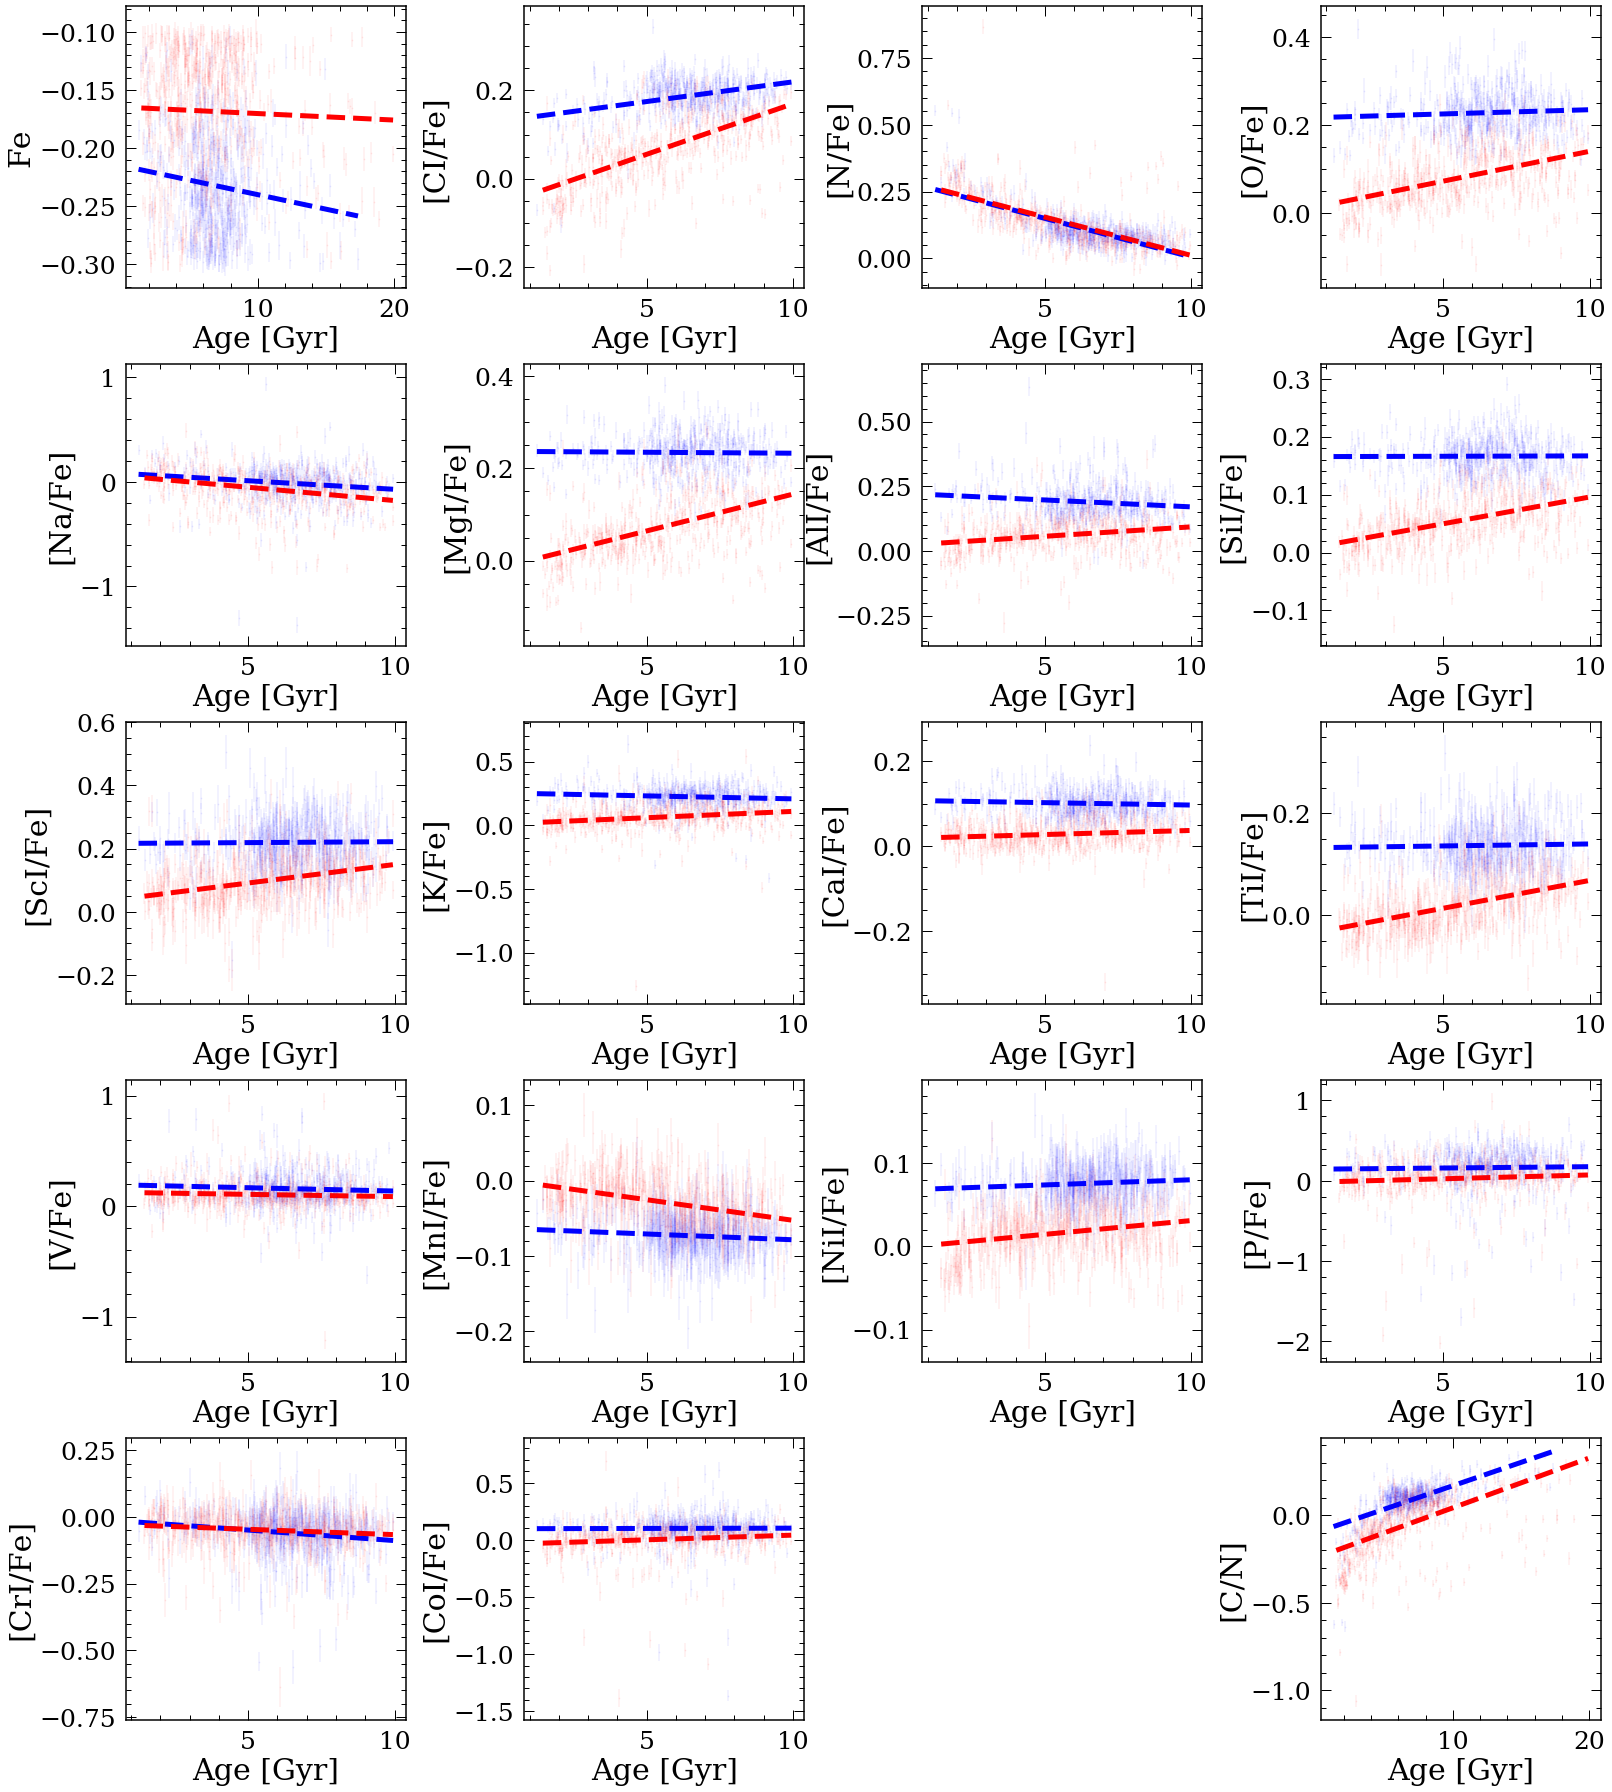

In [43]:
grad_la, grad_la_err, grad_ha, grad_ha_err, Abunname = getgrad(df_abun_st_ha,df_abun_st_la)

In [44]:
Abunname=[i.split('/')[0].split('[')[-1] for i in Abunname]
Abunname[-1]='C/N'
df_grad=pd.DataFrame(np.array((Abunname,grad_la, grad_la_err, grad_ha, grad_ha_err)).T,
                     columns=['Abund','la_grad','la_grad_err','ha_grad','ha_grad_err'])
df_grad



Abund                 la_grad             la_grad_err  \
0     CI    0.008934210990258479  0.00041204871582115174   
1      N   -0.028882179646282792    0.000596935418669135   
2      O   0.0019194909735894214   0.0004192194620221337   
3     Na   -0.016377760781069003   0.0014008497191574738   
4    MgI  -0.0004131399275178952   0.0003189056241116942   
5    AlI   -0.005343717863277534   0.0005425619591930304   
6    SiI  0.00013077243696287346   0.0003426858458878093   
7    ScI   0.0005769807615656874   0.0010170688259823922   
8      K   -0.004654149856683047   0.0011819285532040026   
9    CaI   -0.001129486415250225  0.00044227331770522554   
10   TiI   0.0007847026487360452   0.0005219531277485637   
11     V   -0.006000377446096527   0.0016144065632806336   
12   MnI  -0.0015398891637001292    0.000552980212187396   
13   NiI   0.0012373584117291404   0.0004347765833416064   
14     P    0.003339103167610542   0.0022454157191431775   
15   CrI   -0.007912214990912051   0.0010993144846913072   
16   CoI   0.0004986462385237668   0.0012740712215883543   
17    Fe   -0.002500156029605487   0.0001512853916113877   
18   C/N     0.02668979055100657   0.0004927254892342078   

                  ha_grad             ha_grad_err  
0     0.02294748874991293  0.00025924077519892403  
1    -0.02871508468887217   0.0004107874755508547  
2     0.01355975030380971  0.00030521383449561636  
3   -0.025348401596061297   0.0008520804114940713  
4    0.015959778659138692    0.000261712124355595  
5    0.007302942352568135  0.00046310254041845967  
6    0.009223556005828323  0.00019930054557592818  
7    0.011741575266151005   0.0006484800629847303  
8    0.009939577019932318    0.000839200167798951  
9   0.0019230042039439174  0.00031785565107217005  
10   0.010912211416363933  0.00036769002145886653  
11  -0.004090934331326182   0.0011828995423811496  
12  -0.005474600974792224  0.00034625203006864974  
13   0.003311224400018346   0.0002767683522704894  
14   0.009544132547112318   0.0014700921201510403  
15  -0.004019545545898261   0.0008306657136140938  
16   0.008193793090708933    0.000975653771132413  
17  -0.000561210620104826   9.247471273551307e-05  
18    0.02847391944091874   0.0003594708083712507

In [46]:
df_disp_plot=pd.merge(df_disp,df_disp_rc,left_on='Abund',right_on='Abund',how='inner')
for i in df_disp_plot.columns:
    if i!='Abund':
        df_disp_plot[i]=[float(j) for j in df_disp_plot[i]]
#df_disp_plot.to_pickle('intrinsic.pkl')
df_disp_plot['Abund'].iloc[18]='C/N'
df_disp_plot=pd.merge(df_disp_plot,df_grad,left_on='Abund',right_on='Abund',how='inner')
df_disp_plot['la_grad']=[float(i) for i in df_disp_plot['la_grad']]
df_disp_plot['la_grad_err']=[float(i) for i in df_disp_plot['la_grad_err']]
df_disp_plot['ha_grad']=[float(i) for i in df_disp_plot['ha_grad']]
df_disp_plot['ha_grad_err']=[float(i) for i in df_disp_plot['ha_grad_err']]

/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [47]:
#df_disp_plot.to_pickle('intrinsic.pkl')
df_disp_plot['diff']=abs(df_disp_plot['la_grad']-df_disp_plot['ha_grad'])

In [48]:
df_disp_plot=df_disp_plot.sort_values(by='diff',ascending=False)

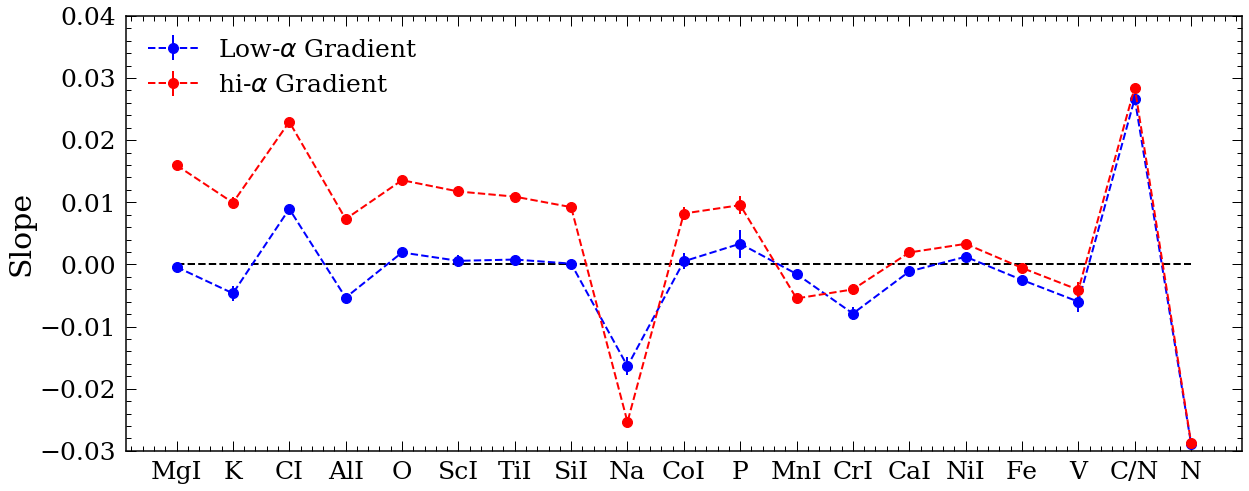

In [49]:
plt.figure(figsize=(20,8))
plt.errorbar(df_disp_plot['Abund'],df_disp_plot['la_grad'],yerr=df_disp_plot['la_grad_err'],
             fmt='bo--',label='Low-$\\alpha$ Gradient',markersize=10)
plt.errorbar(df_disp_plot['Abund'],df_disp_plot['ha_grad'],yerr=df_disp_plot['ha_grad_err'],
             fmt='ro--',label='hi-$\\alpha$ Gradient',markersize=10)
plt.plot(df_disp_plot['Abund'],np.zeros(len(df_disp_plot['Abund'])),'k--')

plt.ylim([-0.03,0.04])
plt.ylabel('Slope')
plt.legend()
#plt.savefig('slopes.png')

In [50]:
df_disp_plot.to_pickle('intrinsic_cluster.pkl')